In [204]:
import numpy as np
np.bool=bool
np.int=int
np.float=float
import nibabel
import glob
import os
import sys
import subprocess
import cifti
#from brainspace.null_models import MoranRandomization
#from brainspace.mesh import mesh_elements as me
#import scipy.io as sio
#import mat73
from scipy import sparse
import pickle
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
import scipy.stats

from scipy.stats import levene
from statsmodels.tools import add_constant
from statsmodels.formula.api import ols ## use formula api to make the tests easier
import matplotlib
from nibabel import cifti2 as ci
import copy
#import nipy
#from nipy.modalities.fmri import hrf
#from nipy.modalities.fmri.utils import T, lambdify_t

import seaborn as sns

from scipy.signal import hilbert, chirp

import re
from datetime import date

import nilearn
import nilearn.plotting
import random
from sklearn.metrics import r2_score
from scipy.cluster import hierarchy
from sklearn.decomposition import PCA,TruncatedSVD

In [3]:
import mat73

In [4]:
from brainspace.null_models import MoranRandomization
from brainspace.mesh import mesh_elements as me

# initial set up for the database

In [5]:
# subject specific networks

networks=[
    nibabel.load(path+'/Evan/MSC/Analysis_V1/infomap/MSC02_infomap_p003_p005_p05/MSC02_rawassn_minsize400_regularized_recolored_cleaned.dscalar.nii').dataobj[0][:29696+29716],
    nibabel.load(path+'/Evan/MSC/Analysis_V1/infomap/MSC06_infomap_p003_p005_p05/MSC06_rawassn_minsize400_regularized_recolored_cleaned.dscalar.nii').dataobj[0][:29696+29716],
    nibabel.load(path+'/Dillan/cast/MSC_analyses/infomap/SIC03_sparse/SIC03_rawassn_minsize100_regularized_recolored_cleaned.dscalar.nii').dataobj[0][:29696+29716]
]



networkname=['Default','Visual','Fronto-Parietal','PrimaryVisual','DorsalAttention','PreMotor','VentralAttentionLanguage','Salience','Cingulo-Opercular','MotorHand','MotorMouth','Auditory','AntMedialTemporal/SNR noise','PostMedialTemporal','Cingulo-Parietal','Parieto-Occipital','MotorFoot']
networkcolor=[[1,0,0],[0,0,0.6],[0.9,0.9,0],[1,0.7,0.4],[0,0.8,0],[1,0.6,1],[0,0.6,0.6],[0,0,0],[0.3,0,0.6],[0.2,1,1],[1,0.5,0],[0.6,0.2,1],[0,0.2,0.4],[0.2,1,0.2],[0,0,1],[0.85,0.85,0.85],[0,0.5,0]]

In [6]:
sub = ['SIC01','SIC02','SIC03']

In [7]:
spots=[1.5,2.5,6.6]# SCAN values in the files
netspotCorVol=[copy.deepcopy(np.array(nibabel.load(path+'/Evan/CIMT/Subnetworks/'+s+'_precast_infomap_wacky2_subcortreg_ignoreverts/'+s+'_rawassn_minsize10_regularized_recolored_wCMI.dscalar.nii').dataobj[0])) for s in sub]
netspot=[copy.deepcopy(np.array(nibabel.load(path+'/Evan/CIMT/Subnetworks/'+s+'_precast_infomap_wacky2_subcortreg_ignoreverts/'+s+'_rawassn_minsize10_regularized_recolored_wCMI.dscalar.nii').dataobj[0][:29696+29716])) for s in sub]

netspotCorVol[0]=copy.deepcopy(np.array(nibabel.load(path+'/RosCha/RestProcessing/cast/smooth255/SIC01/FC/infomap/SIC01_rawassn_minsize10_regularized_recolored.dscalar.nii').dataobj[0]))
netspot[0]=copy.deepcopy(np.array(nibabel.load(path+'/RosCha/RestProcessing/cast/smooth255/SIC01/FC/infomap/SIC01_rawassn_minsize10_regularized_recolored.dscalar.nii').dataobj[0][:29696+29716]))


netspotname=['Default','SCAN','Visual','Fronto-Parietal','PrimaryVisual','DorsalAttention','PreMotor','VentralAttentionLanguage','Salience','Cingulo-Opercular','MotorHand','MotorMouth','Auditory','AntMedialTemporal/SNR noise','PostMedialTemporal','Cingulo-Parietal','Parieto-Occipital','MotorFoot']
netspotcolor=[[1,0,0],[0.9,0,0.6],[0,0,0.6],[0.9,0.9,0],[1,0.7,0.4],[0,0.8,0],[1,0.6,1],[0,0.6,0.6],[0,0,0],[0.3,0,0.6],[0.2,1,1],[1,0.5,0],[0.6,0.2,1],[0,0.2,0.4],[0.2,1,0.2],[0,0,1],[0.85,0.85,0.85],[0,0.5,0]]
netspotval=[1,1.5,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]

In [8]:

ciftilocnet=[path+'/RosCha/Tools/nifti/'+sub[s]+'_rawassn_minsize10_regularized_recolored_wCMIas18.dscalar.nii' for s in range(len(sub))]

netspotnameMOD=['Default','Visual','Fronto-Parietal','Primary Visual','Dorsal Attention','Peri-Motor','Ventral Attention','Salience','Cingulo-Opercular','Motor Hand','Motor Mouth','Auditory','Ant. Medial Temporal','Post. Medial Temporal','Cingulo-Parietal','Parieto-Occipital','Motor Foot','Somato-Cognitive Action']
netspotcolorMOD=[[1,0,0],[0,0,0.6],[0.9,0.9,0],[1,0.7,0.4],[0,0.8,0],[1,0.6,1],[0,0.6,0.6],[0,0,0],[0.3,0,0.6],[0.2,1,1],[1,0.5,0],[0.6,0.2,1],[0,0.2,0.4],[0.2,1,0.2],[0,0,1],[0.85,0.85,0.85],[0,0.5,0],[0.6,0.15,0.36]]
netspotvalMOD=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]


In [9]:
#color palette
mypal_net=dict()
for e,m in enumerate(networkname):
    mypal_net.update({m:np.array(networkcolor[e])})



In [10]:
#precast task based
HandDillan=[
    np.array([np.int(i) for i in open(path+'/RosCha/Tools/nifti/MSC02/motor_spots/DillanMotorHand.txt','r').read().split('\n') if i!='']),
    np.array([np.int(i) for i in open(path+'/RosCha/Tools/nifti/SIC02/DillanMotorHand.txt','r').read().split('\n') if i!='']),
    np.array([np.int(i) for i in open(path+'/RosCha/Tools/nifti/SIC03/DillanMotorHand.txt','r').read().split('\n') if i!=''])
]
HandDillan[0][np.where(HandDillan[0]>6)]=0
HandDillan[1][np.where(HandDillan[1]>6)]=0
HandDillan[2][np.where(HandDillan[2]>6)]=0
HandDillanname=['L_M1','R_M1','L_sma','R_sma','Ltemp','Rtemp']

In [11]:
# time plot pre post
#load the list of vc pre post : 
pplist=[[] for s in range(len(sub))]
for e,s in enumerate(sub):
    pplist[e]=[[i for i in open(path+'/RosCha/Data/Precision/motor/'+s+'/conditionlist/'+p+'cast.txt','r').read().split('\n') if i!=''] for p in ['pre','post']]+[[i for i in open(path+'/RosCha/Data/Precision/rest/'+s+'/conditionlist/during.txt','r').read().split('\n') if i!='']]
    for j in range(3):
        pplistorder=np.argsort([np.int(i.replace('vc','').replace('_motor','').replace('_rest_','')) for i in pplist[e][j]])
        if e==0 and j==2:
            pplistorder=np.concatenate([pplistorder[4:6],pplistorder[:4],pplistorder[6:]],0)
        pplist[e][j]=[pplist[e][j][i] for i in pplistorder]
    

In [12]:
datelist=[[] for s in range(len(sub))]
for e,s in enumerate(sub):
    datelist[e]=[i.split('_') for i in open(path+'/RosCha/Data/Precision/eventfiles/castsessions/'+s+'_session_date.txt','r').read().split('\n') if i!='']

In [13]:
import seaborn
def fdr(p_vals):

    from scipy.stats import rankdata
    ranked_p_values = rankdata(p_vals)
    fdr = p_vals * len(p_vals) / ranked_p_values
    fdr[fdr > 1] = 1

    return fdr

In [14]:
# do regression
def regression(data, design, mask='', demean=True, desnorm=False, resids=False):
    
    import numpy as np
        
    # Y = Xb + e
    # process Y
    
    Y = data[mask==1,:]
    
    # process X
    if design.shape[0] == Y.shape[1]:
        X = design
        
    else:
        X = design[mask==1,:]
        
    
    if demean == True:
        #demean Y
        if Y.shape[0] == X.shape[0]:
            Y = Y - np.average(Y,axis=0)
        else:
            # demean the data, subtract mean over time from each voxel
            Y = Y - np.tile(np.average(Y, axis=1), (Y.shape[1],1)).T
    
        # demean the design
        X = X - np.average(X,axis=0)#np.repeat(np.mean(X,0),len(X[0]))#.mean(axis=0)
    
    if desnorm == True:
        # variance normalize the design
        X = X/X.std(axis=0, ddof=1)

    # add constant to X
    constant = np.ones(X.shape[0])
    X = np.column_stack((constant,X))
    
    if Y.shape[1] == X.shape[0]:
        # put time in rows for regression against time course
        Y = Y.T
    
    # obtain betas
    B = np.linalg.pinv(X).dot(Y)
    # obtain residuals
    #print Y.shape, X.shape, B.shape
    eta = Y - X.dot(B)
    #print eta.shape
    
    # put betas back into image if needed
    if max(B.shape) == max(Y.shape):
        bi = np.zeros((B.shape[0],max(data.shape)))
        bi[:,mask==1] = B
        B = bi
    
    # put residuals back into image
    if resids == True:
        ei = np.zeros_like(data)
        ei[mask==1,:] = eta.T
        eta = ei
        
    # return betas and design
    # discard first beta, this is the constant
    if resids == True:
        return B[1:,:], eta
    else:
        return B[1:,:]

# visu functions

In [12]:
def plotsurf(ciftiloc,vmin=None,vmax=None,palette='',savefig='', threshold=None, cbar_vmin=None, cbar_vmax=None,background=True,avg='mean',rollZ=0,rollX=0,scale=0.8):
    if ciftiloc[len(ciftiloc)-len('dtseries.nii'):]=='dtseries.nii':
        tag='dtseries'
    else:
        tag='dscalar'
    if palette=='':
        palette=sns.diverging_palette(250, 30, l=65, as_cmap=True)
    subprocess.call(['wb_command','-cifti-separate-all',ciftiloc,'-volume',ciftiloc.replace('.'+tag+'.nii','_vol.nii.gz'),'-left',ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),'-right',ciftiloc.replace('.'+tag+'.nii','_R.func.gii')])

    figure, axes = plt.subplots(2,2,subplot_kw={'projection': '3d'},figsize=(35,25))

    mapL="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.L.inflated.32k_fs_LR.surf.gii"
    mapR="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.R.inflated.32k_fs_LR.surf.gii"
    bgL="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.L.32k_fs_LR.shape.gii"
    bgR="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.R.32k_fs_LR.shape.gii"
    nilearn.plotting.plot_surf(mapL,surf_map=ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),vmin=vmin,vmax=vmax,hemi='left', view='lateral',cmap=palette, bg_map=bgL,bg_on_data=background, darkness=0.4,axes=axes[0][0],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)
    
    nilearn.plotting.plot_surf(mapR, surf_map=ciftiloc.replace('.'+tag+'.nii','_R.func.gii'),vmin=vmin,vmax=vmax,hemi='right', view='lateral',cmap=palette, bg_map=bgR,bg_on_data=background, darkness=0.4,axes=axes[0][1],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)

    nilearn.plotting.plot_surf(mapL, surf_map=ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),vmin=vmin,vmax=vmax,hemi='left', view='medial',cmap=palette, bg_map=bgL,bg_on_data=background, darkness=0.4,axes=axes[1][0],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)

    nilearn.plotting.plot_surf(mapR, surf_map=ciftiloc.replace('.'+tag+'.nii','_R.func.gii'),vmin=vmin,vmax=vmax,hemi='right', view='medial',cmap=palette, bg_map=bgR,bg_on_data=background, darkness=0.4,axes=axes[1][1],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)
    plt.tight_layout()
    
    for ax in range(len(axes)):
        for ax2 in range(len(axes[0])):
            elev=axes[ax][ax2].elev+rollZ*(-1*ax+1*(np.abs(ax-1)))
            azim=axes[ax][ax2].azim+rollX*(-1*ax2+1*(np.abs(ax2-1)))
            axes[ax][ax2].view_init(elev,azim)
            prov=axes[ax][ax2].get_xlim()
            axes[ax][ax2].set_xlim3d(prov[0]*scale,prov[1]*scale)
            prov=axes[ax][ax2].get_zlim()
            axes[ax][ax2].set_zlim3d(prov[0]*scale,prov[1]*scale)
            prov=axes[ax][ax2].get_ylim()
            axes[ax][ax2].set_ylim3d(prov[0]*scale,prov[1]*scale)
            
    if savefig!='':
        plt.savefig(savefig)
    plt.show()
    
    nilearn.plotting.plot_surf(mapR, surf_map=ciftiloc.replace('.'+tag+'.nii','_R.func.gii'),vmin=vmin,vmax=vmax,hemi='right', view='medial',cmap=palette, bg_map=bgR,bg_on_data=background, darkness=0.4,colorbar=True, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg)
    if savefig!='':
        plt.savefig(savefig[:savefig.rfind('.')]+'-colorbar'+savefig[savefig.rfind('.'):])
    plt.show()
    subprocess.call(['rm',ciftiloc.replace('.'+tag+'.nii','_vol.nii.gz'),ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),ciftiloc.replace('.'+tag+'.nii','_R.func.gii')])

In [13]:
def plotsurfwithcont(ciftiloc,img_contour,contval,contcolor,vmin=None,vmax=None,palette='',savefig='', threshold=None, cbar_vmin=None, cbar_vmax=None,background=True,avg='mean',rollZ=0,rollX=0,scale=0.8):
    if ciftiloc[len(ciftiloc)-len('dtseries.nii'):]=='dtseries.nii':
        tag='dtseries'
    else:
        tag='dscalar'
    if img_contour[len(img_contour)-len('dtseries.nii'):]=='dtseries.nii':
        tag2='dtseries'
    else:
        tag2='dscalar'
    if palette=='':
        palette=sns.diverging_palette(250, 30, l=65, as_cmap=True)
    subprocess.call(['wb_command','-cifti-separate-all',ciftiloc,'-volume',ciftiloc.replace('.'+tag+'.nii','_vol.nii.gz'),'-left',ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),'-right',ciftiloc.replace('.'+tag+'.nii','_R.func.gii')])

    figure, axes = plt.subplots(2,2,subplot_kw={'projection': '3d'},figsize=(35,25))

    mapL="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.L.inflated.32k_fs_LR.surf.gii"
    mapR="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.R.inflated.32k_fs_LR.surf.gii"
    bgL="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.L.32k_fs_LR.shape.gii"
    bgR="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.R.32k_fs_LR.shape.gii"
    nilearn.plotting.plot_surf(mapL,surf_map=ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),vmin=vmin,vmax=vmax,hemi='left', view='lateral',cmap=palette, bg_map=bgL,bg_on_data=background, darkness=0.4,axes=axes[0][0],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)

    nilearn.plotting.plot_surf(mapR, surf_map=ciftiloc.replace('.'+tag+'.nii','_R.func.gii'),vmin=vmin,vmax=vmax,hemi='right', view='lateral',cmap=palette, bg_map=bgR,bg_on_data=background, darkness=0.4,axes=axes[0][1],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)

    nilearn.plotting.plot_surf(mapL, surf_map=ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),vmin=vmin,vmax=vmax,hemi='left', view='medial',cmap=palette, bg_map=bgL,bg_on_data=background, darkness=0.4,axes=axes[1][0],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)

    nilearn.plotting.plot_surf(mapR, surf_map=ciftiloc.replace('.'+tag+'.nii','_R.func.gii'),vmin=vmin,vmax=vmax,hemi='right', view='medial',cmap=palette, bg_map=bgR,bg_on_data=background, darkness=0.4,axes=axes[1][1],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)
    
    subprocess.call(['wb_command','-cifti-separate-all',img_contour,'-volume',img_contour.replace('.'+tag2+'.nii','_vol.nii.gz'),'-left',img_contour.replace('.'+tag2+'.nii','_L.func.gii'),'-right',img_contour.replace('.'+tag2+'.nii','_R.func.gii')])
    for c in range(len(contcolor)):
        nilearn.plotting.plot_surf_contours(mapL,img_contour.replace('.'+tag2+'.nii','_L.func.gii'), levels=[contval[c]], colors=[contcolor[c]],axes=axes[0][0],figure=figure,alpha=1)
        #(surf_mesh, roi_map, axes=None, figure=None, levels=None, labels=None, colors=None, legend=False, cmap='tab20', title=None, output_file=None, **kwargs)[source]

        nilearn.plotting.plot_surf_contours(mapR,img_contour.replace('.'+tag2+'.nii','_R.func.gii'), levels=[contval[c]], colors=[contcolor[c]],axes=axes[0][1],figure=figure,alpha=1)
        nilearn.plotting.plot_surf_contours(mapL,img_contour.replace('.'+tag2+'.nii','_L.func.gii'), levels=[contval[c]], colors=[contcolor[c]],axes=axes[1][0],figure=figure,alpha=1)
        nilearn.plotting.plot_surf_contours(mapR,img_contour.replace('.'+tag2+'.nii','_R.func.gii'), levels=[contval[c]], colors=[contcolor[c]],axes=axes[1][1],figure=figure,alpha=1)
    plt.tight_layout()
    
    for ax in range(len(axes)):
        for ax2 in range(len(axes[0])):
            elev=axes[ax][ax2].elev+rollZ*(-1*ax+1*(np.abs(ax-1)))
            azim=axes[ax][ax2].azim+rollX*(-1*ax2+1*(np.abs(ax2-1)))
            axes[ax][ax2].view_init(elev,azim)
            prov=axes[ax][ax2].get_xlim()
            axes[ax][ax2].set_xlim3d(prov[0]*scale,prov[1]*scale)
            prov=axes[ax][ax2].get_zlim()
            axes[ax][ax2].set_zlim3d(prov[0]*scale,prov[1]*scale)
            prov=axes[ax][ax2].get_ylim()
            axes[ax][ax2].set_ylim3d(prov[0]*scale,prov[1]*scale)
            
    if savefig!='':
        plt.savefig(savefig)
    plt.show()
    
    nilearn.plotting.plot_surf(mapR, surf_map=ciftiloc.replace('.'+tag+'.nii','_R.func.gii'),vmin=vmin,vmax=vmax,hemi='right', view='medial',cmap=palette, bg_map=bgR,bg_on_data=background, darkness=0.4,colorbar=True, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg)
    if savefig!='':
        plt.savefig(savefig[:savefig.rfind('.')]+'-colorbar'+savefig[savefig.rfind('.'):])
    plt.show()
    subprocess.call(['rm',ciftiloc.replace('.'+tag+'.nii','_vol.nii.gz'),ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),ciftiloc.replace('.'+tag+'.nii','_R.func.gii')])
    subprocess.call(['rm',img_contour.replace('.'+tag2+'.nii','_vol.nii.gz'),img_contour.replace('.'+tag2+'.nii','_L.func.gii'),img_contour.replace('.'+tag2+'.nii','_R.func.gii')])

In [14]:
def plotsurfwithroi(ciftiloc,roi,roival=1,vmin=None,vmax=None,palette='',savefig='', threshold=None, cbar_vmin=None, cbar_vmax=None,background=True,avg='mean',rollZ=0,rollX=0,scale=0.8):
    if roi[len(roi)-len('dtseries.nii'):]=='dtseries.nii':
        tag3='dtseries'
    else:
        tag3='dscalar'
    raw=nibabel.load(roi)
    data=copy.deepcopy(np.array(raw.dataobj[0]))
    data[np.where(data!=roival)]=0
    data[np.where(data==roival)]=1
    
    
    axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
    # You'll want the brain model axis
    time_axis, brain_model_axis = axes
    
    if tag3=='dscalar':
        time_axis2=nibabel.cifti2.cifti2_axes.ScalarAxis(['val'])
    else:
        time_axis2=nibabel.cifti2.cifti2_axes.SeriesAxis(1,1,1)
    img=ci.Cifti2Image(np.array([data]), header=(time_axis2, brain_model_axis),
            nifti_header=raw.nifti_header)
    ci.save(img,roi.replace('.'+tag3+'.nii','_valselect.'+tag3+'.nii'))
     
    
    roi=roi.replace('.'+tag3+'.nii','_valselect.'+tag3+'.nii')
    print(roi)
    if ciftiloc[len(ciftiloc)-len('dtseries.nii'):]=='dtseries.nii':
        tag='dtseries'
    else:
        tag='dscalar'
    
    
    if palette=='':
        palette=sns.diverging_palette(250, 30, l=65, as_cmap=True)
    subprocess.call(['wb_command','-cifti-separate-all',ciftiloc,'-volume',ciftiloc.replace('.'+tag+'.nii','_vol.nii.gz'),'-left',ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),'-right',ciftiloc.replace('.'+tag+'.nii','_R.func.gii')])

    figure, axes = plt.subplots(2,2,subplot_kw={'projection': '3d'},figsize=(35,25))
    
    mapL="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.L.inflated.32k_fs_LR.surf.gii"
    mapR="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.R.inflated.32k_fs_LR.surf.gii"
    bgL="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.L.32k_fs_LR.shape.gii"
    bgR="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.R.32k_fs_LR.shape.gii"
    nilearn.plotting.plot_surf(mapL,surf_map=ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),vmin=vmin,vmax=vmax,hemi='left', view='lateral',cmap=palette, bg_map=bgL,bg_on_data=background, darkness=0.5,axes=axes[0][0],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)

    nilearn.plotting.plot_surf(mapR, surf_map=ciftiloc.replace('.'+tag+'.nii','_R.func.gii'),vmin=vmin,vmax=vmax,hemi='right', view='lateral',cmap=palette, bg_map=bgR,bg_on_data=background, darkness=0.5,axes=axes[0][1],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)

    nilearn.plotting.plot_surf(mapL, surf_map=ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),vmin=vmin,vmax=vmax,hemi='left', view='medial',cmap=palette, bg_map=bgL,bg_on_data=background, darkness=0.5,axes=axes[1][0],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)

    nilearn.plotting.plot_surf(mapR, surf_map=ciftiloc.replace('.'+tag+'.nii','_R.func.gii'),vmin=vmin,vmax=vmax,hemi='right', view='medial',cmap=palette, bg_map=bgR,bg_on_data=background, darkness=0.5,axes=axes[1][1],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)
    
    subprocess.call(['wb_command','-cifti-separate-all',roi,'-volume',roi.replace('.'+tag3+'.nii','_vol.nii.gz'),'-left',roi.replace('.'+tag3+'.nii','_L.func.gii'),'-right',roi.replace('.'+tag3+'.nii','_R.func.gii')])
    try:       
        nilearn.plotting.plot_surf_contours(mapL,roi.replace('.'+tag3+'.nii','_L.func.gii'), axes=axes[0][0],figure=figure, levels=[1],colors=['k'],filled=True)
        nilearn.plotting.plot_surf_contours(mapL, roi.replace('.'+tag3+'.nii','_L.func.gii'),axes=axes[1][0],figure=figure, levels=[1],colors=['k'],filled=True)
    except:
        print('nothing on left hemi roi')
    try:
        nilearn.plotting.plot_surf_contours(mapR, roi.replace('.'+tag3+'.nii','_R.func.gii'), axes=axes[0][1],figure=figure, levels=[1],colors=['k'],filled=True)
        nilearn.plotting.plot_surf_contours(mapR,roi.replace('.'+tag3+'.nii','_R.func.gii'),axes=axes[1][1],figure=figure, levels=[1],colors=['k'],filled=True)
    except:
        print('nothing on right hemi roi')
    
    plt.tight_layout()
    
    for ax in range(len(axes)):
        for ax2 in range(len(axes[0])):
            elev=axes[ax][ax2].elev+rollZ*(-1*ax+1*(np.abs(ax-1)))
            azim=axes[ax][ax2].azim+rollX*(-1*ax2+1*(np.abs(ax2-1)))
            axes[ax][ax2].view_init(elev,azim)
            prov=axes[ax][ax2].get_xlim()
            axes[ax][ax2].set_xlim3d(prov[0]*scale,prov[1]*scale)
            prov=axes[ax][ax2].get_zlim()
            axes[ax][ax2].set_zlim3d(prov[0]*scale,prov[1]*scale)
            prov=axes[ax][ax2].get_ylim()
            axes[ax][ax2].set_ylim3d(prov[0]*scale,prov[1]*scale)
            
    if savefig!='':
        plt.savefig(savefig)
    
    plt.show()
    
    nilearn.plotting.plot_surf(mapR, surf_map=ciftiloc.replace('.'+tag+'.nii','_R.func.gii'),vmin=vmin,vmax=vmax,hemi='right', view='medial',cmap=palette, bg_map=bgR,bg_on_data=background, darkness=0.5,colorbar=True, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg)
    if savefig!='':
        plt.savefig(savefig[:savefig.rfind('.')]+'-colorbar'+savefig[savefig.rfind('.'):])
    plt.show()
    subprocess.call(['rm',ciftiloc.replace('.'+tag+'.nii','_vol.nii.gz'),ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),ciftiloc.replace('.'+tag+'.nii','_R.func.gii')])
    subprocess.call(['rm',roi.replace('.'+tag3+'.nii','_vol.nii.gz'),roi.replace('.'+tag3+'.nii','_L.func.gii'),roi.replace('.'+tag3+'.nii','_R.func.gii')])

In [34]:
def plotsurfwithcontNroi(ciftiloc,img_contour,roi,contval,contcolor,roival=1,vmin=None,vmax=None,palette='',savefig='', threshold=None, cbar_vmin=None, cbar_vmax=None,background=True,avg='mean',rollZ=0,rollX=0,scale=0.8):
    if roi[len(roi)-len('dtseries.nii'):]=='dtseries.nii':
        tag3='dtseries'
    else:
        tag3='dscalar'
    raw=nibabel.load(roi)
    data=copy.deepcopy(np.array(raw.dataobj[0]))
    data[np.where(data!=roival)]=0
    data[np.where(data==roival)]=1
    
    
    axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
    # You'll want the brain model axis
    time_axis, brain_model_axis = axes
    
    if tag3=='dscalar':
        time_axis2=nibabel.cifti2.cifti2_axes.ScalarAxis(['val'])
    else:
        time_axis2=nibabel.cifti2.cifti2_axes.SeriesAxis(1,1,1)
    img=ci.Cifti2Image(np.array([data]), header=(time_axis2, brain_model_axis),
            nifti_header=raw.nifti_header)
    ci.save(img,roi.replace('.'+tag3+'.nii','_valselect.'+tag3+'.nii'))
     
    
    roi=roi.replace('.'+tag3+'.nii','_valselect.'+tag3+'.nii')
    
    if ciftiloc[len(ciftiloc)-len('dtseries.nii'):]=='dtseries.nii':
        tag='dtseries'
    else:
        tag='dscalar'
    if img_contour[len(img_contour)-len('dtseries.nii'):]=='dtseries.nii':
        tag2='dtseries'
    else:
        tag2='dscalar'
    
    if palette=='':
        palette=sns.diverging_palette(250, 30, l=65, as_cmap=True)
    subprocess.call(['wb_command','-cifti-separate-all',ciftiloc,'-volume',ciftiloc.replace('.'+tag+'.nii','_vol.nii.gz'),'-left',ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),'-right',ciftiloc.replace('.'+tag+'.nii','_R.func.gii')])

    figure, axes = plt.subplots(2,2,subplot_kw={'projection': '3d'},figsize=(35,25))
    
    mapL="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.L.inflated.32k_fs_LR.surf.gii"
    mapR="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.R.inflated.32k_fs_LR.surf.gii"
    bgL="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.L.32k_fs_LR.shape.gii"
    bgR="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.R.32k_fs_LR.shape.gii"
    nilearn.plotting.plot_surf(mapL,surf_map=ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),vmin=vmin,vmax=vmax,hemi='left', view='lateral',cmap=palette, bg_map=bgL,bg_on_data=background, darkness=0.5,axes=axes[0][0],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)

    nilearn.plotting.plot_surf(mapR, surf_map=ciftiloc.replace('.'+tag+'.nii','_R.func.gii'),vmin=vmin,vmax=vmax,hemi='right', view='lateral',cmap=palette, bg_map=bgR,bg_on_data=background, darkness=0.5,axes=axes[0][1],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)

    nilearn.plotting.plot_surf(mapL, surf_map=ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),vmin=vmin,vmax=vmax,hemi='left', view='medial',cmap=palette, bg_map=bgL,bg_on_data=background, darkness=0.5,axes=axes[1][0],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)

    nilearn.plotting.plot_surf(mapR, surf_map=ciftiloc.replace('.'+tag+'.nii','_R.func.gii'),vmin=vmin,vmax=vmax,hemi='right', view='medial',cmap=palette, bg_map=bgR,bg_on_data=background, darkness=0.5,axes=axes[1][1],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)
    
    subprocess.call(['wb_command','-cifti-separate-all',roi,'-volume',roi.replace('.'+tag3+'.nii','_vol.nii.gz'),'-left',roi.replace('.'+tag3+'.nii','_L.func.gii'),'-right',roi.replace('.'+tag3+'.nii','_R.func.gii')])
    try:       
        nilearn.plotting.plot_surf_contours(mapL,roi.replace('.'+tag3+'.nii','_L.func.gii'), axes=axes[0][0],figure=figure, levels=[1],colors=['k'],filled=True)
        nilearn.plotting.plot_surf_contours(mapL, roi.replace('.'+tag3+'.nii','_L.func.gii'),axes=axes[1][0],figure=figure, levels=[1],colors=['k'],filled=True)
    except:
        print('nothing on left hemi roi')
    try:
        nilearn.plotting.plot_surf_contours(mapR, roi.replace('.'+tag3+'.nii','_R.func.gii'), axes=axes[0][1],figure=figure, levels=[1],colors=['k'],filled=True)
        nilearn.plotting.plot_surf_contours(mapR,roi.replace('.'+tag3+'.nii','_R.func.gii'),axes=axes[1][1],figure=figure, levels=[1],colors=['k'],filled=True)
    except:
        print('nothing on right hemi roi')
    
    subprocess.call(['wb_command','-cifti-separate-all',img_contour,'-volume',img_contour.replace('.'+tag2+'.nii','_vol.nii.gz'),'-left',img_contour.replace('.'+tag2+'.nii','_L.func.gii'),'-right',img_contour.replace('.'+tag2+'.nii','_R.func.gii')])
    for c in range(len(contcolor)):
        
        nilearn.plotting.plot_surf_contours(mapL,img_contour.replace('.'+tag2+'.nii','_L.func.gii'), levels=[contval[c]], colors=[contcolor[c]],axes=axes[0][0],figure=figure,alpha=1)#,alpha=0.5)
        nilearn.plotting.plot_surf_contours(mapR,img_contour.replace('.'+tag2+'.nii','_R.func.gii'), levels=[contval[c]], colors=[contcolor[c]],axes=axes[0][1],figure=figure,alpha=1)#,alpha=0.5)
        nilearn.plotting.plot_surf_contours(mapL,img_contour.replace('.'+tag2+'.nii','_L.func.gii'), levels=[contval[c]], colors=[contcolor[c]],axes=axes[1][0],figure=figure,alpha=1)#,alpha=0.5)
        nilearn.plotting.plot_surf_contours(mapR,img_contour.replace('.'+tag2+'.nii','_R.func.gii'), levels=[contval[c]], colors=[contcolor[c]],axes=axes[1][1],figure=figure,alpha=1)#,alpha=0.5)
    for ax in range(len(axes)):
        for ax2 in range(len(axes[0])):
            elev=axes[ax][ax2].elev+rollZ*(-1*ax+1*(np.abs(ax-1)))
            azim=axes[ax][ax2].azim+rollX*(-1*ax2+1*(np.abs(ax2-1)))
            axes[ax][ax2].view_init(elev,azim)
    plt.tight_layout()
    
    for ax in range(len(axes)):
        for ax2 in range(len(axes[0])):
            prov=axes[ax][ax2].get_xlim()
            axes[ax][ax2].set_xlim3d(prov[0]*scale,prov[1]*scale)
            prov=axes[ax][ax2].get_zlim()
            axes[ax][ax2].set_zlim3d(prov[0]*scale,prov[1]*scale)
            prov=axes[ax][ax2].get_ylim()
            axes[ax][ax2].set_ylim3d(prov[0]*scale,prov[1]*scale)
            
    if savefig!='':
        plt.savefig(savefig)
    
    plt.show()
    
    nilearn.plotting.plot_surf(mapR, surf_map=ciftiloc.replace('.'+tag+'.nii','_R.func.gii'),vmin=vmin,vmax=vmax,hemi='right', view='medial',cmap=palette, bg_map=bgR,bg_on_data=background, darkness=0.5,colorbar=True, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg)
    if savefig!='':
        plt.savefig(savefig[:savefig.rfind('.')]+'-colorbar'+savefig[savefig.rfind('.'):])
    plt.show()
    subprocess.call(['rm',ciftiloc.replace('.'+tag+'.nii','_vol.nii.gz'),ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),ciftiloc.replace('.'+tag+'.nii','_R.func.gii')])
    subprocess.call(['rm',img_contour.replace('.'+tag2+'.nii','_vol.nii.gz'),img_contour.replace('.'+tag2+'.nii','_L.func.gii'),img_contour.replace('.'+tag2+'.nii','_R.func.gii')])
    subprocess.call(['rm',roi.replace('.'+tag3+'.nii','_vol.nii.gz'),roi.replace('.'+tag3+'.nii','_L.func.gii'),roi.replace('.'+tag3+'.nii','_R.func.gii')])

# atlas transform

In [ ]:
#### bring subcortical atlas to 333
for s,net in enumerate(ciftilocnet):
    
    #subcorticalmask=path+'/Dillan/preproc_2018-07-03/'+sub[s]+'/subcortical_mask_222/subcortical_mask_LR_222.nii'
    subcorticaldir=path+'/Dillan/preproc_2018-07-03/'+sub[s]+'/subcortical_mask_222'
    #if s==0:
    subcorticalmask=path+'/Dillan/preproc_2018-07-03/'+sub[s]+'/subcortical_mask/subcortical_mask_LR_333.nii'
    
    #separate
    tag3='dscalar'
    
    subprocess.call(['wb_command','-cifti-separate-all',net,'-volume',net.replace('.'+tag3+'.nii','_vol.nii.gz'),'-left',net.replace('.'+tag3+'.nii','_L.func.gii'),'-right',net.replace('.'+tag3+'.nii','_R.func.gii')])

    #read volume
    raw=nibabel.load(net.replace('.'+tag3+'.nii','_vol.nii.gz'))
    
    vol=raw.get_fdata()
    #make 4d for each structure
    val=np.unique(vol)
    print(vol.shape)
    vol4d=np.zeros((vol.shape[0],vol.shape[1],vol.shape[2],len(val)))
    vol4d=vol4d.T
    vol=vol.T
    for n2,n in enumerate(val):
        prov=np.zeros(vol.shape)
        prov[np.where(vol==n)]=1
        vol4d[n2]=prov
    
    #save
    nibabel.save(nibabel.Nifti1Image(vol4d.T, affine=raw.affine),net.replace('.'+tag3+'.nii','_vol_4d.nii.gz'))
    #reshape
    subprocess.call(['flirt','-in',net.replace('.'+tag3+'.nii','_vol_4d.nii.gz'),'-ref',subcorticalmask,'-applyxfm','-usesqform','-out',net.replace('.'+tag3+'.nii','_vol_4d_333.nii.gz')])
    #>0.5 binarize
    #subprocess.call(['fslmaths', net.replace('.'+tag3+'.nii','_vol_4d_333.nii.gz'),'-thr','0.5','-bin',net.replace('.'+tag3+'.nii','_vol_4d_333BIN.nii.gz')])
    #load
    raw2=nibabel.load(net.replace('.'+tag3+'.nii','_vol_4d_333.nii.gz'))
    bin4d=raw2.get_fdata()
    print(bin4d.shape)
    bin4d=bin4d.T
    #WTA#back to 3D
    prov=np.argmax(bin4d,axis=0)
    bin3d=np.zeros(prov.shape)
    
    for v2,v in enumerate(val):
        bin3d[np.where(prov==v2)]=v
    #save volume
    nibabel.save(nibabel.Nifti1Image(bin3d.T, affine=raw2.affine),net.replace('.'+tag3+'.nii','_vol_333.nii.gz'))
    
    Subcortical=net.replace('.'+tag3+'.nii','_vol_333.nii.gz')
    leftfile=net.replace('.'+tag3+'.nii','_L.func.gii')
    rightfile=net.replace('.'+tag3+'.nii','_R.func.gii')
    #combine to cifti
    subprocess.call(['wb_command','-cifti-create-dense-timeseries',net.replace('.'+tag3+'.nii','_castshape.dtseries.nii'),'-volume',Subcortical,subcorticalmask,'-left-metric',leftfile,'-roi-left',subcorticaldir+'/L.atlasroi.32k_fs_LR.shape.gii','-right-metric',rightfile,'-roi-right',subcorticaldir+'/R.atlasroi.32k_fs_LR.shape.gii'])
    #clean up
    #subprocess.call(['rm',net.replace('.'+tag3+'.nii','_vol.nii.gz'),net.replace('.'+tag3+'.nii','_L.func.gii'),net.replace('.'+tag3+'.nii','_R.func.gii'),net.replace('.'+tag3+'.nii','_vol_4d.nii.gz'),net.replace('.'+tag3+'.nii','_vol_4d_333.nii.gz'),net.replace('.'+tag3+'.nii','_vol_4d_333BIN.nii.gz'),net.replace('.'+tag3+'.nii','_vol_333.nii.gz')])

In [163]:
####need to bring subcortical atlas to 333
for s in range(3):
    n=0
    raw2=[]
    raw3=[]
    for l in labelssegmentTHOMAS:
        print(l)
        net=path+'/RosCha/Structurals/cast/THOMAS/'+sub[s]+'/'+l+'.nii.gz'
        raw3+=[nibabel.load(net).get_fdata()]
        #subcorticalmask=path+'/Dillan/preproc_2018-07-03/'+sub[s]+'/subcortical_mask_222/subcortical_mask_LR_222.nii'
        subcorticaldir=path+'/Dillan/preproc_2018-07-03/'+sub[s]+'/subcortical_mask_222'
        #if s==0:
        subcorticalmask=path+'/Dillan/preproc_2018-07-03/'+sub[s]+'/subcortical_mask/subcortical_mask_LR_333.nii'


        #reshape
        subprocess.call(['flirt','-in',net,'-ref',subcorticalmask,'-applyxfm','-usesqform','-out',net.replace('.nii.gz','_castshape.nii.gz')])
        #>0.5 binarize
        subprocess.call(['fslmaths',net.replace('.nii.gz','_castshape.nii.gz'),'-thr','0.2','-bin',net.replace('.nii.gz','_castshape_BIN.nii.gz')])
        #load
        raw2+=[nibabel.load(net.replace('.nii.gz','_castshape.nii.gz')).get_fdata()]
    raw2_3d=np.argmax(raw2,0)+1
    raw2_3d[np.where(np.sum(raw2,0)==0)]=0
    #save volume
    nibabel.save(nibabel.Nifti1Image(raw2_3d, affine=nibabel.load(net.replace('.nii.gz','_castshape.nii.gz')).affine),os.path.dirname(os.path.dirname(net))+'thomasfull_castshape.nii.gz')
    raw3_3d=np.argmax(raw3,0)+1
    raw3_3d[np.where(np.sum(raw3,0)==0)]=0
    #save volume
    nibabel.save(nibabel.Nifti1Image(raw3_3d, affine=nibabel.load(net).affine),os.path.dirname(os.path.dirname(net))+'thomasfull_T1.nii.gz')
    

left/2-AV
left/4-VA
left/5-VLa
left/6_VLPv
left/6_VLPd
left/7-VPL
left/8-Pul
left/9-LGN
left/10-MGN
left/11-CM
left/12-MD-Pf
left/13-Hb
left/14-MTT
right/2-AV
right/4-VA
right/5-VLa
right/6_VLPv
right/6_VLPd
right/7-VPL
right/8-Pul
right/9-LGN
right/10-MGN
right/11-CM
right/12-MD-Pf
right/13-Hb
right/14-MTT
left/2-AV
left/4-VA
left/5-VLa
left/6_VLPv
left/6_VLPd
left/7-VPL
left/8-Pul
left/9-LGN
left/10-MGN
left/11-CM
left/12-MD-Pf
left/13-Hb
left/14-MTT
right/2-AV
right/4-VA
right/5-VLa
right/6_VLPv
right/6_VLPd
right/7-VPL
right/8-Pul
right/9-LGN
right/10-MGN
right/11-CM
right/12-MD-Pf
right/13-Hb
right/14-MTT
left/2-AV
left/4-VA
left/5-VLa
left/6_VLPv
left/6_VLPd
left/7-VPL
left/8-Pul
left/9-LGN
left/10-MGN
left/11-CM
left/12-MD-Pf
left/13-Hb
left/14-MTT
right/2-AV
right/4-VA
right/5-VLa
right/6_VLPv
right/6_VLPd
right/7-VPL
right/8-Pul
right/9-LGN
right/10-MGN
right/11-CM
right/12-MD-Pf
right/13-Hb
right/14-MTT


# visu function and color scale 

In [21]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]
def get_continuous_cmap(hex_list, float_list=None,N=256):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=N)
    return cmp

In [22]:

black=np.array([0,0,0])
white=np.array([1,1,1])
grayscale=get_continuous_cmap(sns.color_palette([black,white]).as_hex())

def plotZslices_alloption(niftipath,mnipath='',ortho='z',cut_coords='',Nraw=1,smoothing=None,LR=False,outdir='',colorpos='r',colorneg='b',Zannotate=False,thresholdpos='def',Zannotates='def',thresholdneg=False,alphamap=1,alphabrain=1):
    "niftipath: path to the nifti file, can be a 3D - if activation map, specify thresholds,"
    "mnipath : path to the mni T1 brain"
    "cut_coords can be a int as the number of zslices to display of a list of slices number (in MNI) (even list of one to get one specific slice)"
    "Nraw: the number of raw"
    "smoothing: number of voxel to smooth; LR:annotate left and right"
    "outdir:path to save the file"
    "color:list of color for each volume, or only one color, neg or pos if corresponding threshold to display"
    "Zannotate : Number=annotate z number, False=not annotate, Brain=on a X slice, with lign, or Both"
    "thresholdpos: specify threshold to cut and see above (can be a list for activation map: layer effect) or False will not be displayed or 'def' as 0.5 on normalized file"
    "thresholdneg: specify threshold to cut and see bellow (can be a list for activation map: layer effect) or False will not be displayed "
    import matplotlib.pyplot as plt
    import numpy as np
    import nilearn.plotting
    import nilearn.image   
    from nilearn.plotting import plot_roi, plot_stat_map
    from nilearn.plotting.find_cuts import find_cut_slices
    from nilearn.image.image import mean_img
    import nibabel
    import seaborn as sns
    initialcol=sns.light_palette((0,0,0), as_cmap=True)#'Greys'
    data=nibabel.load(niftipath)
    datasize=data.shape
    lineW=1./(Nraw+int((Zannotate=='Brain' or Zannotate=='Both')))
    
    mnipathtour='/opt/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz'
    if not os.path.exists(mnipathtour):
        mnipathtour='/usr/local/pkg/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz'
        
    if mnipath=='':
        mnipath='/opt/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz' ##this only works for the donders institute (Nijmegen, The Neterlands)
        valmni=[5000]
    else:
        valmni=[i for i in np.unique(nibabel.load(mnipath).get_fdata()) if i!=0]
    if type(cut_coords)==int or cut_coords=='':
        if cut_coords=='':
            cut_coords=6
        #find best cut
        if len(datasize)==4:
            #for 4D nifti
            cut_coords=find_cut_slices(mean_img(nibabel.nifti1.Nifti1Image(np.sign(np.abs(data.get_fdata())),data.affine)), n_cuts=cut_coords)
            print('4',cut_coords)
        else:
            #for 3D nifti
            cut_coords=find_cut_slices(data, n_cuts=cut_coords)
            print('3',cut_coords)
    
    #split in N raw
    if cut_coords!=(0,0,0):
        cut_coords=np.array(cut_coords)
        cc=cut_coords
        cut_coords=[cut_coords[int(i*len(cut_coords)/np.float(Nraw)):int((i+1)*len(cut_coords)/np.float(Nraw))] for i in range(Nraw)]
    else:
        cut_coords=[cut_coords]
    #define color as a vector (length :the number of volume):
    #if not enought color are proveded, the last of them is repeated
    #color are defined independantly for negative value display and positive value display
    if type(colorneg)==str:
        colorneg=[colorneg]
    if type(colorpos)==str:
        colorpos=[colorpos]
    if len(datasize)==4 and len(colorpos)!=datasize[3]:
        provcol=colorpos[len(colorpos)-1]
        colorpos=np.concatenate([colorpos,[provcol for i in range(datasize[3]-len(colorpos))]])
    if len(datasize)==4 and len(colorneg)!=datasize[3]:
        provcol=colorneg[len(colorneg)-1]
        colorneg=np.concatenate([colorneg,[provcol for i in range(datasize[3]-len(colorneg))]])

    #adjust threshold by normalizing image in the default version and taking 0.5
    if type(thresholdpos)==str:
        data=nibabel.nifti1.Nifti1Image(data.get_fdata()/np.float(np.max(data.get_fdata())),data.affine)
        thresholdpos=[0.5]
    #organize thresholds, more than 1 threshold to make a layer effect,
    #positive and negative values display are treated independantly:
    if type(thresholdpos)!=np.bool: thresholdpos=[i for i in np.sort(thresholdpos)]
    if type(thresholdneg)!=np.bool: 
        if np.sum(thresholdneg)<0:
            thresholdneg=[i for i in -np.sort(-1*np.array(thresholdneg))]
        else:
            thresholdneg=[i for i in np.sort(thresholdneg)]
    #load data to create a white backgroung
    func=mean_img(nibabel.nifti1.Nifti1Image(np.sign(np.abs(data.get_fdata())),data.affine))
    
    ####################subplot
    for i in range(Nraw):
        
        ax=plt.subplot(Nraw+int((Zannotate=='Brain' or Zannotate=='Both')),1,i+1)
        
        #plot the white backgroung as a zeros value brain (without it, the view focus aroung the first area plotted)
        brain=nilearn.plotting.plot_roi(nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine), nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine),colorbar=False,cut_coords=cut_coords[i],display_mode=ortho,alpha=1,draw_cross=False,cmap=initialcol,black_bg=False,axes=ax,annotate=False)
        
        ###############plot the volumes for Z brain slices
        if len(datasize)==3:
            iter_imgs=[data]
        else:
            iter_imgs=nilearn.image.iter_img(niftipath)
        
        j=0
        for img in iter_imgs:
            
            ##plot the positive values
            if thresholdpos!=False:
                if len(thresholdpos)==len(colorpos):
                    colorprovpos=colorpos
                else:
                    colorprovpos=sns.light_palette(colorpos[j],len(thresholdpos),reverse=True)[::-1]
                
                
                img2=nilearn.image.smooth_img(img,smoothing)
                ##plot the different threshold (layer effect) for the positive values
                for kn,k in enumerate(thresholdpos):
                    
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovpos[kn][0],colorprovpos[kn][1],colorprovpos[kn][2]]],alpha=1)#alphamap)       linewidths=lineW,             
            ##plot the negative values   
            if thresholdneg!=False:
                if len(thresholdneg)==len(colorneg):
                    
                    colorprovneg=colorneg
                else:
                    
                    colorprovneg=sns.light_palette(colorneg[j],len(thresholdneg),reverse=True)[::-1]
                #switch negative to positive
                img2=nibabel.nifti1.Nifti1Image(-1*nilearn.image.smooth_img(img,smoothing).get_fdata(),data.affine)
                ##plot the negatives values for each negative threshold
                for kn,k in enumerate(thresholdneg):
                    
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovneg[kn][0],colorprovneg[kn][1],colorprovneg[kn][2]]],alpha=1)#alphamap)         linewidths=lineW,           
                  
            j+=1
        ##plot the brain contour for Z brain slices
        #externe
        brain.add_contours(nilearn.image.smooth_img(mnipathtour,5),alpha=1*alphabrain, levels=[95],linewidths=lineW, cmap=grayscale)#sns.dark_palette('w', as_cmap=True),)       
        if mnipath==mnipathtour:
            keepsmooth=nilearn.image.smooth_img(mnipath,0.5)
            brain.add_contours(keepsmooth,alpha=0.8*alphabrain, levels=[5000],linewidths=lineW, cmap=grayscale)#sns.dark_palette('w', as_cmap=True),)
        else:
            keepsmooth=nibabel.load(mnipath)
            for v in valmni:
                prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
                prov[np.where(prov!=v)]=0
                keepsmoothprov=nibabel.Nifti1Image(prov, affine=keepsmooth.affine)
                brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, levels=[v],linewidths=lineW, cmap=grayscale)
        #add annotation if reauested
        if Zannotate=='Both' or Zannotate=='Number' :
            brain.annotate(left_right=LR,size=int(12*lineW))
        
        print('raw '+str(i)+' ready')

        
    ########################## plot the X brain (same process but on X)
    if Zannotate=='Brain' or Zannotate=='Both':
        print('doing annotate X slice')
        ax=plt.subplot(Nraw+1,1,Nraw+1)
        if len(datasize)==4:
            cut_coords=find_cut_slices(mean_img(nibabel.nifti1.Nifti1Image(np.sign(np.abs(data.get_fdata())),data.affine)), n_cuts=1,direction='x')
        else:
            cut_coords=find_cut_slices(data, n_cuts=1,direction='x')
        
        #plot the white background Xbrain
        brain=nilearn.plotting.plot_roi(nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine), nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine),colorbar=False,cut_coords=cut_coords,display_mode='x',alpha=1,draw_cross=False,cmap=initialcol,black_bg=False,axes=ax,annotate=False)
        
        if Zannotate=='Both' or Zannotate=='Number' :
            brain.annotate(left_right=LR,size=int(12*lineW))
            
        if len(datasize)==3:
            iter_imgs=[data]
        else:
            iter_imgs=nilearn.image.iter_img(niftipath)
        #plot the volumes
        j=0
        for img in iter_imgs:
            if thresholdpos!=False:
                if len(thresholdpos)==len(colorpos):
                    colorprovpos=colorpos
                else:
                    colorprovpos=sns.light_palette(colorpos[j],len(thresholdpos),reverse=True)[::-1]
                img2=nilearn.image.smooth_img(img,smoothing)
                
                for kn,k in enumerate(thresholdpos):
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovpos[kn][0],colorprovpos[kn][1],colorprovpos[kn][2]]],alpha=1)#alphamap)                    linewidths=lineW,
                    
            if thresholdneg!=False:
                if len(thresholdneg)==len(colorneg):
                    colorprovneg=colorpneg
                else:
                    colorprovneg=sns.light_palette(colorneg[j],len(thresholdneg),reverse=True)[::-1]
                img2=nibabel.nifti1.Nifti1Image(-1*nilearn.image.smooth_img(img,smoothing).get_fdata(),data.affine)
                for kn,k in enumerate(thresholdneg):
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovneg[kn][0],colorprovneg[kn][1],colorprovneg[kn][2]]],alpha=1)#alphamap)                    linewidths=lineW,
                
            j+=1
        brain.add_contours(nilearn.image.smooth_img(mnipathtour,5),alpha=1*alphabrain, levels=[95],linewidths=lineW, cmap=grayscale)#sns.dark_palette('w', as_cmap=True),)       
        if mnipath==mnipathtour:
            keepsmooth=nilearn.image.smooth_img(mnipath,0.5)
            brain.add_contours(keepsmooth,alpha=0.8*alphabrain, levels=[5000],linewidths=lineW, cmap=grayscale)#sns.dark_palette('w', as_cmap=True),)
        else:
            keepsmooth=nibabel.load(mnipath)
            for v in valmni:
                prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
                prov[np.where(prov!=v)]=0
                keepsmoothprov=nibabel.Nifti1Image(prov, affine=keepsmooth.affine)
                brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, levels=[v],linewidths=lineW, cmap=grayscale)#sns.dark_palette('w', as_cmap=True),)
        ##plot the line indicating the cut
        for i in cc:
            ax.plot([-100, 100], [i, i], 'k-',lw=lineW)#/(85.+73.)
        ax.axis((-300.0, 300.0, -80.0, 110.0))   
    #save
    if outdir!='':
        plt.savefig(outdir,dpi=300)

In [181]:

black=np.array([0,0,0])
white=np.array([1,1,1])
grayscale=get_continuous_cmap(sns.color_palette([black,white]).as_hex())
grayscale2=get_continuous_cmap(sns.color_palette([white,white]).as_hex())

def plotZslices_alloptionT1(niftipath,mnipath='',T1='',ortho='z',cut_coords='',Nraw=1,smoothing=None,LR=False,outdir='',colorpos='r',colorneg='b',Zannotate=False,thresholdpos='def',Zannotates='def',thresholdneg=False,alphamap=1,alphabrain=1):
    "niftipath: path to the nifti file, can be a 3D - if activation map, specify thresholds,"
    "mnipath : path to the mni T1 brain"
    "cut_coords can be a int as the number of zslices to display of a list of slices number (in MNI) (even list of one to get one specific slice)"
    "Nraw: the number of raw"
    "smoothing: number of voxel to smooth; LR:annotate left and right"
    "outdir:path to save the file"
    "color:list of color for each volume, or only one color, neg or pos if corresponding threshold to display"
    "Zannotate : Number=annotate z number, False=not annotate, Brain=on a X slice, with lign, or Both"
    "thresholdpos: specify threshold to cut and see above (can be a list for activation map: layer effect) or False will not be displayed or 'def' as 0.5 on normalized file"
    "thresholdneg: specify threshold to cut and see bellow (can be a list for activation map: layer effect) or False will not be displayed "
    import matplotlib.pyplot as plt
    import numpy as np
    import nilearn.plotting
    import nilearn.image   
    from nilearn.plotting import plot_roi, plot_stat_map
    from nilearn.plotting.find_cuts import find_cut_slices
    from nilearn.image.image import mean_img
    import nibabel
    import seaborn as sns
    initialcol=sns.light_palette((0,0,0), as_cmap=True)#'Greys'
    data=nibabel.load(niftipath)
    datasize=data.shape
    lineW=1./(Nraw+int((Zannotate=='Brain' or Zannotate=='Both')))
    
    mnipathtour='/opt/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz'
    if not os.path.exists(mnipathtour):
        mnipathtour='/usr/local/pkg/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz'
        
    if mnipath=='':
        mnipath='/opt/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz' ##this only works for the donders institute (Nijmegen, The Neterlands)
        valmni=[5000]
    else:
        valmni=[i for i in np.unique(nibabel.load(mnipath).get_fdata()) if i!=0]
    if type(cut_coords)==int or cut_coords=='':
        if cut_coords=='':
            cut_coords=6
        #find best cut
        if len(datasize)==4:
            #for 4D nifti
            cut_coords=find_cut_slices(mean_img(nibabel.nifti1.Nifti1Image(np.sign(np.abs(data.get_fdata())),data.affine)), n_cuts=cut_coords)
            print('4',cut_coords)
        else:
            #for 3D nifti
            cut_coords=find_cut_slices(data, n_cuts=cut_coords)
            print('3',cut_coords)
    
    #split in N raw
    if cut_coords!=(0,0,0):
        cut_coords=np.array(cut_coords)
        cc=cut_coords
        cut_coords=[cut_coords[int(i*len(cut_coords)/np.float(Nraw)):int((i+1)*len(cut_coords)/np.float(Nraw))] for i in range(Nraw)]
    else:
        cut_coords=[cut_coords]
    #define color as a vector (length :the number of volume):
    #if not enought color are proveded, the last of them is repeated
    #color are defined independantly for negative value display and positive value display
    if type(colorneg)==str:
        colorneg=[colorneg]
    if type(colorpos)==str:
        colorpos=[colorpos]
    if len(datasize)==4 and len(colorpos)!=datasize[3]:
        provcol=colorpos[len(colorpos)-1]
        colorpos=np.concatenate([colorpos,[provcol for i in range(datasize[3]-len(colorpos))]])
    if len(datasize)==4 and len(colorneg)!=datasize[3]:
        provcol=colorneg[len(colorneg)-1]
        colorneg=np.concatenate([colorneg,[provcol for i in range(datasize[3]-len(colorneg))]])

    #adjust threshold by normalizing image in the default version and taking 0.5
    if type(thresholdpos)==str:
        data=nibabel.nifti1.Nifti1Image(data.get_fdata()/np.float(np.max(data.get_fdata())),data.affine)
        thresholdpos=[0.5]
    #organize thresholds, more than 1 threshold to make a layer effect,
    #positive and negative values display are treated independantly:
    if type(thresholdpos)!=np.bool: thresholdpos=[i for i in np.sort(thresholdpos)]
    if type(thresholdneg)!=np.bool: 
        if np.sum(thresholdneg)<0:
            thresholdneg=[i for i in -np.sort(-1*np.array(thresholdneg))]
        else:
            thresholdneg=[i for i in np.sort(thresholdneg)]
    #load data to create a white backgroung
    func=mean_img(nibabel.nifti1.Nifti1Image(np.sign(np.abs(data.get_fdata())),data.affine))
    if T1=='':
        T1=nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine)
    ####################subplot
    for i in range(Nraw):
        
        ax=plt.subplot(Nraw+int((Zannotate=='Brain' or Zannotate=='Both')),1,i+1)
        
        #plot the white backgroung as a zeros value brain (without it, the view focus aroung the first area plotted)
        brain=nilearn.plotting.plot_roi(nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine), T1,dim='auto',colorbar=False,cut_coords=cut_coords[i],display_mode=ortho,alpha=1,draw_cross=False,cmap=initialcol,black_bg=False,axes=ax,annotate=False)
        
        ###############plot the volumes for Z brain slices
        if len(datasize)==3:
            iter_imgs=[data]
        else:
            iter_imgs=nilearn.image.iter_img(niftipath)
        
        j=0
        for img in iter_imgs:
            
            ##plot the positive values
            if thresholdpos!=False:
                if len(thresholdpos)==len(colorpos):
                    colorprovpos=colorpos
                else:
                    colorprovpos=sns.light_palette(colorpos[j],len(thresholdpos),reverse=True)[::-1]
                
                
                img2=nilearn.image.smooth_img(img,smoothing)
                ##plot the different threshold (layer effect) for the positive values
                for kn,k in enumerate(thresholdpos):
                    
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovpos[kn][0],colorprovpos[kn][1],colorprovpos[kn][2]]],alpha=1)#alphamap)       linewidths=lineW,             
            ##plot the negative values   
            if thresholdneg!=False:
                if len(thresholdneg)==len(colorneg):
                    
                    colorprovneg=colorneg
                else:
                    
                    colorprovneg=sns.light_palette(colorneg[j],len(thresholdneg),reverse=True)[::-1]
                #switch negative to positive
                img2=nibabel.nifti1.Nifti1Image(-1*nilearn.image.smooth_img(img,smoothing).get_fdata(),data.affine)
                ##plot the negatives values for each negative threshold
                for kn,k in enumerate(thresholdneg):
                    
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovneg[kn][0],colorprovneg[kn][1],colorprovneg[kn][2]]],alpha=1)#alphamap)         linewidths=lineW,           
                  
            j+=1
        ##plot the brain contour for Z brain slices
        #externe
        ########brain.add_contours(nilearn.image.smooth_img(mnipathtour,5),alpha=1*alphabrain, levels=[95],linewidths=lineW, cmap=grayscale)#sns.dark_palette('w', as_cmap=True),)       
        if mnipath==mnipathtour:
            keepsmooth=nilearn.image.smooth_img(mnipath,0.5)
            brain.add_contours(keepsmooth,alpha=0.5*alphabrain, levels=[5000],linewidths=lineW, cmap=grayscale)#sns.dark_palette('w', as_cmap=True),)
        else:
            keepsmooth=nibabel.load(mnipath)
            for v in valmni:
                prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
                prov[np.where(prov!=v)]=0
                keepsmoothprov=nibabel.Nifti1Image(prov, affine=keepsmooth.affine)
                brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, levels=[v-0.000001],linewidths=lineW, cmap=grayscale2)
        #add annotation if reauested
        if Zannotate=='Both' or Zannotate=='Number' :
            brain.annotate(left_right=LR,size=int(12*lineW))
        
        print('raw '+str(i)+' ready')

        
    ########################## plot the X brain (same process but on X)
    if Zannotate=='Brain' or Zannotate=='Both':
        print('doing annotate X slice')
        ax=plt.subplot(Nraw+1,1,Nraw+1)
        if len(datasize)==4:
            cut_coords=find_cut_slices(mean_img(nibabel.nifti1.Nifti1Image(np.sign(np.abs(data.get_fdata())),data.affine)), n_cuts=1,direction='x')
        else:
            cut_coords=find_cut_slices(data, n_cuts=1,direction='x')
        
        #plot the white background Xbrain
        brain=nilearn.plotting.plot_roi(nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine), nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine),colorbar=False,cut_coords=cut_coords,display_mode='x',alpha=1,draw_cross=False,cmap=initialcol,black_bg=False,axes=ax,annotate=False)
        
        if Zannotate=='Both' or Zannotate=='Number' :
            brain.annotate(left_right=LR,size=int(12*lineW))
            
        if len(datasize)==3:
            iter_imgs=[data]
        else:
            iter_imgs=nilearn.image.iter_img(niftipath)
        #plot the volumes
        j=0
        for img in iter_imgs:
            if thresholdpos!=False:
                if len(thresholdpos)==len(colorpos):
                    colorprovpos=colorpos
                else:
                    colorprovpos=sns.light_palette(colorpos[j],len(thresholdpos),reverse=True)[::-1]
                img2=nilearn.image.smooth_img(img,smoothing)
                
                for kn,k in enumerate(thresholdpos):
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovpos[kn][0],colorprovpos[kn][1],colorprovpos[kn][2]]],alpha=1)#alphamap)                    linewidths=lineW,
                    
            if thresholdneg!=False:
                if len(thresholdneg)==len(colorneg):
                    colorprovneg=colorpneg
                else:
                    colorprovneg=sns.light_palette(colorneg[j],len(thresholdneg),reverse=True)[::-1]
                img2=nibabel.nifti1.Nifti1Image(-1*nilearn.image.smooth_img(img,smoothing).get_fdata(),data.affine)
                for kn,k in enumerate(thresholdneg):
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovneg[kn][0],colorprovneg[kn][1],colorprovneg[kn][2]]],alpha=1)#alphamap)                    linewidths=lineW,
                
            j+=1
        brain.add_contours(nilearn.image.smooth_img(mnipathtour,5),alpha=1*alphabrain, levels=[95],linewidths=lineW, cmap=grayscale)#sns.dark_palette('w', as_cmap=True),)       
        if mnipath==mnipathtour:
            keepsmooth=nilearn.image.smooth_img(mnipath,0.5)
            brain.add_contours(keepsmooth,alpha=0.8*alphabrain, levels=[5000],linewidths=lineW, cmap=grayscale)#sns.dark_palette('w', as_cmap=True),)
        else:
            keepsmooth=nibabel.load(mnipath)
            for v in valmni:
                prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
                prov[np.where(prov!=v)]=0
                keepsmoothprov=nibabel.Nifti1Image(prov, affine=keepsmooth.affine)
                brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, levels=[v],linewidths=lineW, cmap=grayscale)#sns.dark_palette('w', as_cmap=True),)
        ##plot the line indicating the cut
        for i in cc:
            ax.plot([-100, 100], [i, i], 'k-',lw=lineW)#/(85.+73.)
        ax.axis((-300.0, 300.0, -80.0, 110.0))   
    #save
    if outdir!='':
        plt.savefig(outdir,dpi=300)

In [24]:
def plotvol(ciftiloc,ortho='z',cut_coords='',Nraw=1,colorpos='r',colorneg='b',savefig='', thresholdneg=False,thresholdpos=False,Zannotate='Both',smoothing=0):
    
    
    subprocess.call(['wb_command','-cifti-separate-all',ciftiloc,'-volume',ciftiloc.replace('.dtseries.nii','_vol.nii.gz'),'-left',ciftiloc.replace('.dtseries.nii','_L.func.gii'),'-right',ciftiloc.replace('.dtseries.nii','_R.func.gii')])
    niftipath=ciftiloc.replace('.dtseries.nii','_vol.nii.gz')
    plotZslices_alloption(niftipath,ortho=ortho,cut_coords=cut_coords,Nraw=Nraw,outdir=savefig,colorpos=colorpos,colorneg=colorneg,Zannotate=Zannotate,thresholdpos=thresholdpos,thresholdneg=thresholdneg,alphamap=1,alphabrain=1,smoothing=smoothing)
    
    
    subprocess.call(['rm',ciftiloc.replace('.dtseries.nii','_vol.nii.gz'),ciftiloc.replace('.dtseries.nii','_L.func.gii'),ciftiloc.replace('.dtseries.nii','_R.func.gii')])

In [25]:
def plotvolindiv(ciftiloc,ortho='z',cut_coords='',Nraw=1,colorpos='r',colorneg='b',savefig='', thresholdneg=False,thresholdpos=False,Zannotate='Both',smoothing=0):
    if ciftiloc[len(ciftiloc)-len('dtseries.nii'):]=='dtseries.nii':
        tag='dtseries'
    else:
        tag='dscalar'
    raw=nibabel.load(ciftiloc)
    data=np.zeros(len(raw.dataobj[0]))
    axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
    # You'll want the brain model axis
    time_axis, brain_model_axis = axes
    #get the structure and make a temp file with level
    keepstructure=[]
    for e,b in enumerate(brain_model_axis.name):
        if b.find('CORTEX')!=-1:
            keepstructure+=[e+1]
        data[np.where(brain_model_axis.name==b)]=e+1
    
    time_axis2=nibabel.cifti2.cifti2_axes.SeriesAxis(1,1,1)
    img=ci.Cifti2Image(np.array([data]), header=(time_axis2, brain_model_axis),
                nifti_header=raw.nifti_header)
    ci.save(img,ciftiloc.replace('.'+tag+'.nii','_structuremask.'+tag+'.nii'))
       
    
    subprocess.call(['wb_command','-cifti-separate-all',ciftiloc.replace('.'+tag+'.nii','_structuremask.'+tag+'.nii'),'-volume',ciftiloc.replace('.'+tag+'.nii','_structuremask_vol.nii.gz'),'-left',ciftiloc.replace('.'+tag+'.nii','_structuremask_L.func.gii'),'-right',ciftiloc.replace('.'+tag+'.nii','_structuremask_R.func.gii')])
    subprocess.call(['wb_command','-cifti-separate-all',ciftiloc,'-volume',ciftiloc.replace('.'+tag+'.nii','_vol.nii.gz'),'-left',ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),'-right',ciftiloc.replace('.'+tag+'.nii','_R.func.gii')])
    niftipath=ciftiloc.replace('.'+tag+'.nii','_vol.nii.gz')
    plotZslices_alloption(niftipath,ciftiloc.replace('.'+tag+'.nii','_structuremask_vol.nii.gz'),ortho=ortho,cut_coords=cut_coords,Nraw=Nraw,outdir=savefig,colorpos=colorpos,colorneg=colorneg,Zannotate=Zannotate,thresholdpos=thresholdpos,thresholdneg=thresholdneg,alphamap=1,alphabrain=1,smoothing=smoothing)
    
    
    subprocess.call(['rm',ciftiloc.replace('.'+tag+'.nii','_vol.nii.gz'),ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),ciftiloc.replace('.'+tag+'.nii','_R.func.gii')])
    subprocess.call(['rm',ciftiloc.replace('.'+tag+'.nii','_structuremask_vol.nii.gz'),ciftiloc.replace('.'+tag+'.nii','_structuremask_L.func.gii'),ciftiloc.replace('.'+tag+'.nii','_structuremask_R.func.gii'),ciftiloc.replace('.'+tag+'.nii','_structuremask.'+tag+'.nii')])

In [177]:
def plotvolindivT1(ciftiloc,T1='',ortho='z',cut_coords='',Nraw=1,colorpos='r',colorneg='b',savefig='', thresholdneg=False,thresholdpos=False,Zannotate='Both',smoothing=0):
    if ciftiloc[len(ciftiloc)-len('dtseries.nii'):]=='dtseries.nii':
        tag='dtseries'
    else:
        tag='dscalar'
    raw=nibabel.load(ciftiloc)
    data=np.zeros(len(raw.dataobj[0]))
    axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
    # You'll want the brain model axis
    time_axis, brain_model_axis = axes
    #get the structure and make a temp file with level
    keepstructure=[]
    for e,b in enumerate(brain_model_axis.name):
        if b.find('CORTEX')!=-1:
            keepstructure+=[e+1]
        data[np.where(brain_model_axis.name==b)]=e+1+0.00001
    
    time_axis2=nibabel.cifti2.cifti2_axes.SeriesAxis(1,1,1)
    img=ci.Cifti2Image(np.array([data]), header=(time_axis2, brain_model_axis),
                nifti_header=raw.nifti_header)
    ci.save(img,ciftiloc.replace('.'+tag+'.nii','_structuremask.'+tag+'.nii'))
       
    
    subprocess.call(['wb_command','-cifti-separate-all',ciftiloc.replace('.'+tag+'.nii','_structuremask.'+tag+'.nii'),'-volume',ciftiloc.replace('.'+tag+'.nii','_structuremask_vol.nii.gz'),'-left',ciftiloc.replace('.'+tag+'.nii','_structuremask_L.func.gii'),'-right',ciftiloc.replace('.'+tag+'.nii','_structuremask_R.func.gii')])
    subprocess.call(['wb_command','-cifti-separate-all',ciftiloc,'-volume',ciftiloc.replace('.'+tag+'.nii','_vol.nii.gz'),'-left',ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),'-right',ciftiloc.replace('.'+tag+'.nii','_R.func.gii')])
    niftipath=ciftiloc.replace('.'+tag+'.nii','_vol.nii.gz')
    plotZslices_alloptionT1(niftipath,ciftiloc.replace('.'+tag+'.nii','_structuremask_vol.nii.gz'),T1=T1,ortho=ortho,cut_coords=cut_coords,Nraw=Nraw,outdir=savefig,colorpos=colorpos,colorneg=colorneg,Zannotate=Zannotate,thresholdpos=thresholdpos,thresholdneg=thresholdneg,alphamap=1,alphabrain=1,smoothing=smoothing)
    
    
    subprocess.call(['rm',ciftiloc.replace('.'+tag+'.nii','_vol.nii.gz'),ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),ciftiloc.replace('.'+tag+'.nii','_R.func.gii')])
    subprocess.call(['rm',ciftiloc.replace('.'+tag+'.nii','_structuremask_vol.nii.gz'),ciftiloc.replace('.'+tag+'.nii','_structuremask_L.func.gii'),ciftiloc.replace('.'+tag+'.nii','_structuremask_R.func.gii'),ciftiloc.replace('.'+tag+'.nii','_structuremask.'+tag+'.nii')])

In [359]:
sns.color_palette("hls", 4)

[(0.86, 0.3712, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86)]

In [23]:
def mycolorscaleDARK(name, show=False, limpos=0,limneg=0, threshold=0,Ncolor=0,reverse=0):
    black=np.array([0,0,0])
    white=np.array([1,1,1])
    
    if name=='grad':
        pos=sns.color_palette("hls", 4)
        neg=sns.color_palette("hls", 4)[::-1]
        zero=[black]
    if name=='salsea':
        pos=sns.color_palette("coolwarm")[::-1][:3]#OrRd")
        pos=np.concatenate([[(pos[0][0]/2.,0,0)],pos])[::-1]
        neg=sns.color_palette('PuBu')#dark_palette("#69d")[1:]
        pos=[(min([neg[x][2]+0.1,1]),max([neg[x][0]-0.1,0]),neg[x][1]-0.2) for x in range(len(neg))][::-1]
        print(pos)
        zero=[black]
        
        
    if name=='greeple':
        #pos=sns.cubehelix_palette(reverse=True, dark=0.1,light=.95)[1:][::-1]
        neg=sns.color_palette('PuBu')[::-1]#dark_palette("#69d")[1:]#trick
        pos=[(neg[x][2],neg[x][0],neg[x][1]) for x in range(len(neg))]
        neg=sns.cubehelix_palette(start=2, rot=0, dark=0.1, light=.85,reverse=True)[::-1]#[1:]
        zero=[black]
    if name=="matket":
        neg=sns.color_palette("mako")[1:][::-1]#mako#np.concatenate([[np.array(sns.color_palette("mako")[1:][0])/2.],sns.color_palette("mako")[1:]],0)
        pos=sns.color_palette("inferno")[1:]#plasma#rocket#np.concatenate([sns.color_palette("rocket")[1:][::-1],[np.array(sns.color_palette("rocket")[1:][0])/2.]],0)
        zero=[black]
        
    if limpos!=0 and threshold!=0:
        if int(len(pos)*threshold/(limpos-threshold))!=0:
        
            zero=np.concatenate([zero,[black for i in range(int(len(pos)*threshold/(limpos-threshold)))]],0)
        
    if limneg!=0 and threshold!=0:
        if int(len(pos)*threshold/(limpos-threshold))!=0:
            zero=np.concatenate([[black for i in range(int(len(neg)*threshold/(np.abs(limneg)-threshold)))],zero],0)
    
        
        
    flatui=np.concatenate([neg,zero,pos],0)
    if reverse:
        flatui=flatui[::-1]
    if Ncolor==0:
        my_cmap = get_continuous_cmap(sns.color_palette(flatui).as_hex())#ListedColormap
    else:
        my_cmap = get_continuous_cmap(sns.color_palette(flatui).as_hex(),N=Ncolor)#ListedColormap
        
    if show:
        x = np.arange(25).reshape(5, 5)
        ax = sns.heatmap(x, cmap=my_cmap)
    return my_cmap


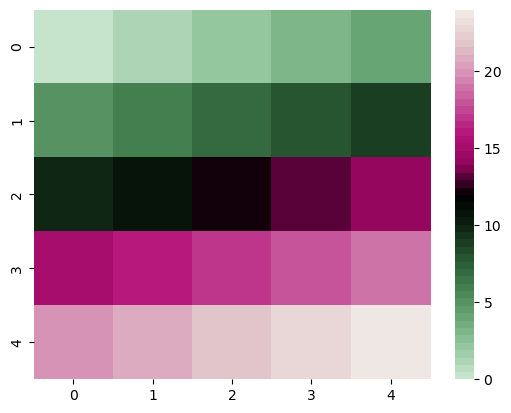

[(0.6707035755478662, 0, 0.1641061130334487), (0.8084044598231449, 0, 0.27563244905805456), (0.8776239907727796, 0.21378700499807765, 0.4058439061899269), (0.9390772779700115, 0.4687043444828912, 0.5082660515186466), (0.989442522106882, 0.6678892733564014, 0.5968473663975393), (1, 0.8112802768166091, 0.6947174163783161)]


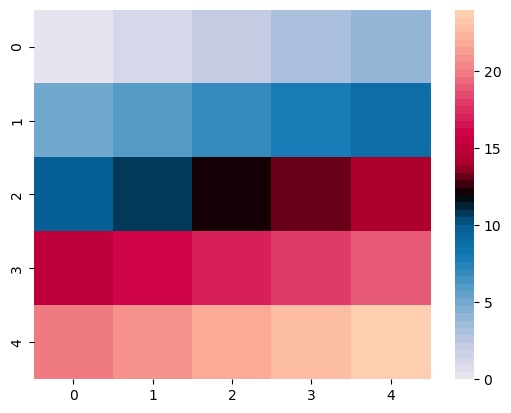

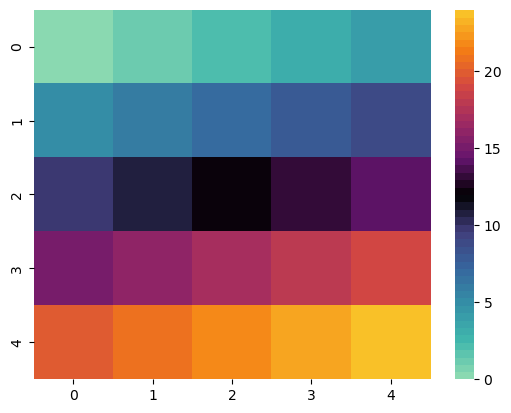

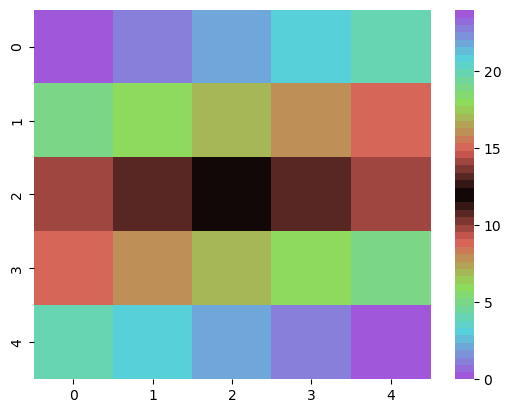

In [366]:
black=np.array([0,0,0])
white=np.array([1,1,1])
# construct cmap
lim=10
thresh=0
x = np.arange(25).reshape(5, 5)
ax = sns.heatmap(x, cmap=mycolorscaleDARK("greeple",limpos=lim,limneg=-lim,threshold=thresh,Ncolor=50))
plt.show()
ax = sns.heatmap(x, cmap=mycolorscaleDARK("salsea",limpos=lim,limneg=-lim,threshold=thresh,Ncolor=50))
plt.show()
ax = sns.heatmap(x, cmap=mycolorscaleDARK("matket",limpos=lim,limneg=-lim,threshold=thresh,Ncolor=50))
plt.show()
ax = sns.heatmap(x, cmap=mycolorscaleDARK("grad",limpos=lim,limneg=-lim,threshold=thresh,Ncolor=50))
plt.show()

In [19]:
def mycolorscale(name, show=False, limpos=0,limneg=0, threshold=0,Ncolor=0,reverse=0):
    black=np.array([0,0,0])
    white=np.array([1,1,1])
    
    if name=='grad':
        pos=sns.color_palette("hls", 4)
        neg=sns.color_palette("hls", 4)[::-1]
        zero=[white]
    if name=='salsea':
        pos=sns.color_palette("coolwarm")[::-1][:3]#OrRd")
        pos=np.concatenate([[(pos[0][0]/2.,0,0)],pos])[::-1]
        neg=sns.color_palette('PuBu')[::-1]#dark_palette("#69d")[1:]
        pos=[(min([neg[x][2]+0.1,1]),max([neg[x][0]-0.1,0]),neg[x][1]-0.2) for x in range(len(neg))][::-1]
        print(pos)
        zero=[white]
    if name=='greeple':
        #pos=sns.cubehelix_palette(reverse=True, dark=0.1,light=.95)[1:][::-1]
        neg=sns.color_palette('PuBu')[::-1]#dark_palette("#69d")[1:]#trick
        pos=[(neg[x][2],neg[x][0],neg[x][1]) for x in range(len(neg))][::-1]
        neg=sns.cubehelix_palette(start=2, rot=0, dark=0.1, light=.85,reverse=True)#[1:]
        zero=[white]
    if name=='greeple2':
        #pos=sns.cubehelix_palette(reverse=True, dark=0.1,light=.95)[1:][::-1]
        neg=sns.color_palette('PuBu')[::-1]#dark_palette("#69d")[1:]#trick
        pos=[(neg[x][2],neg[x][0],neg[x][1]) for x in range(len(neg))][2:][::-1]
        neg=sns.cubehelix_palette(start=2, rot=0, dark=0.1, light=.85,reverse=True)[2:]
        zero=[white]
    if name=="matket":
        neg=sns.color_palette("mako")[1:]#mako#np.concatenate([[np.array(sns.color_palette("mako")[1:][0])/2.],sns.color_palette("mako")[1:]],0)
        pos=sns.color_palette("inferno")[1:][::-1]#plasma#rocket#np.concatenate([sns.color_palette("rocket")[1:][::-1],[np.array(sns.color_palette("rocket")[1:][0])/2.]],0)
        zero=[white]
        
    if limpos!=0 and threshold!=0:
        if int(len(pos)*threshold/(limpos-threshold))!=0:
        
            zero=np.concatenate([zero,[white for i in range(int(len(pos)*threshold/(limpos-threshold)))]],0)
        
    if limneg!=0 and threshold!=0:
        if int(len(pos)*threshold/(limpos-threshold))!=0:
            zero=np.concatenate([[white for i in range(int(len(neg)*threshold/(np.abs(limneg)-threshold)))],zero],0)
    
        
        
    flatui=np.concatenate([neg,zero,pos],0)
    if reverse:
        flatui=flatui[::-1]
    if Ncolor==0:
        my_cmap = get_continuous_cmap(sns.color_palette(flatui).as_hex())#ListedColormap
    else:
        my_cmap = get_continuous_cmap(sns.color_palette(flatui).as_hex(),N=Ncolor)#ListedColormap
        
    if show:
        x = np.arange(25).reshape(5, 5)
        ax = sns.heatmap(x, cmap=my_cmap)
    return my_cmap


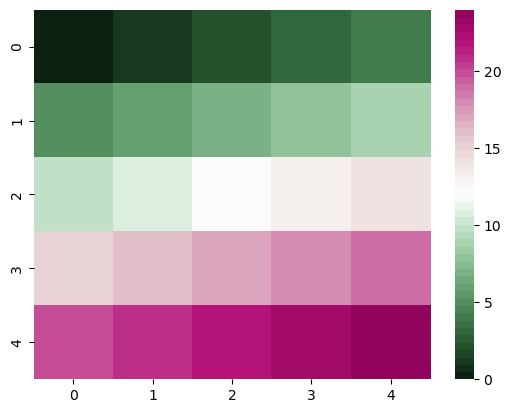

[(1, 0.8112802768166091, 0.6947174163783161), (0.989442522106882, 0.6678892733564014, 0.5968473663975393), (0.9390772779700115, 0.4687043444828912, 0.5082660515186466), (0.8776239907727796, 0.21378700499807765, 0.4058439061899269), (0.8084044598231449, 0, 0.27563244905805456), (0.6707035755478662, 0, 0.1641061130334487)]


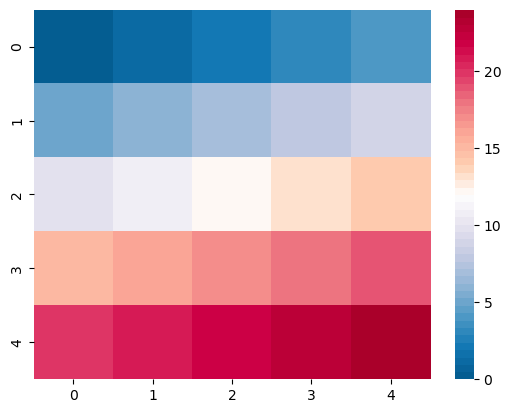

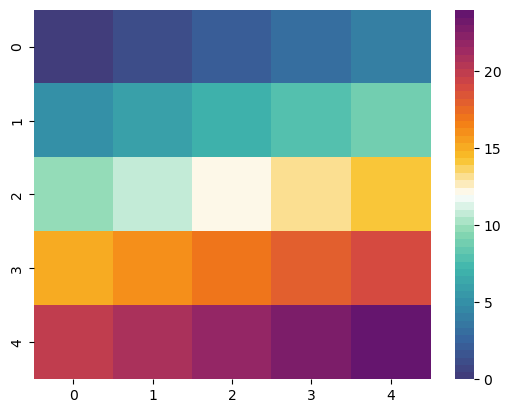

In [358]:
black=np.array([0,0,0])
white=np.array([1,1,1])
# construct cmap
lim=10
thresh=0
x = np.arange(25).reshape(5, 5)
ax = sns.heatmap(x, cmap=mycolorscale("greeple",limpos=lim,limneg=-lim,threshold=thresh,Ncolor=50))
plt.show()
ax = sns.heatmap(x, cmap=mycolorscale("salsea",limpos=lim,limneg=-lim,threshold=thresh,Ncolor=50))
plt.show()
ax = sns.heatmap(x, cmap=mycolorscale("matket",limpos=lim,limneg=-lim,threshold=thresh,Ncolor=50))
plt.show()

In [38]:
import matplotlib.colors as mcolors
def plotsurfwithcontNroiProgress(ciftiloc,img_contour,roi,contval,contcolor,roipos=['LL','LM','RL','RM'],roival=1,vmin=None,vmax=None,palette='',savefig='', threshold=None, cbar_vmin=None, cbar_vmax=None,background=True,avg='mean',rollZ=0,rollX=0,scale=0.8):
    if roi[len(roi)-len('dtseries.nii'):]=='dtseries.nii':
        tag3='dtseries'
    else:
        tag3='dscalar'
    raw=nibabel.load(roi)
    data=copy.deepcopy(np.array(raw.dataobj[0]))
    data[np.where(data!=roival)]=0
    data[np.where(data==roival)]=1
    
    
    axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
    # You'll want the brain model axis
    time_axis, brain_model_axis = axes
    
    if tag3=='dscalar':
        time_axis2=nibabel.cifti2.cifti2_axes.ScalarAxis(['val'])
    else:
        time_axis2=nibabel.cifti2.cifti2_axes.SeriesAxis(1,1,1)
    img=ci.Cifti2Image(np.array([data]), header=(time_axis2, brain_model_axis),
            nifti_header=raw.nifti_header)
    ci.save(img,roi.replace('.'+tag3+'.nii','_valselect.'+tag3+'.nii'))
     
    
    roi=roi.replace('.'+tag3+'.nii','_valselect.'+tag3+'.nii')
    
    if ciftiloc[len(ciftiloc)-len('dtseries.nii'):]=='dtseries.nii':
        tag='dtseries'
    else:
        tag='dscalar'
    if img_contour[len(img_contour)-len('dtseries.nii'):]=='dtseries.nii':
        tag2='dtseries'
    else:
        tag2='dscalar'
    
    if palette=='':
        palette=sns.diverging_palette(250, 30, l=65, as_cmap=True)
    subprocess.call(['wb_command','-cifti-separate-all',ciftiloc,'-volume',ciftiloc.replace('.'+tag+'.nii','_vol.nii.gz'),'-left',ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),'-right',ciftiloc.replace('.'+tag+'.nii','_R.func.gii')])

    figure, axes = plt.subplots(2,2,subplot_kw={'projection': '3d'},figsize=(35,25))
    
    mapL="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.L.inflated.32k_fs_LR.surf.gii"
    mapR="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.R.inflated.32k_fs_LR.surf.gii"
    bgL="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.L.32k_fs_LR.shape.gii"
    bgR="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.R.32k_fs_LR.shape.gii"
    nilearn.plotting.plot_surf(mapL,surf_map=ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),vmin=vmin,vmax=vmax,hemi='left', view='lateral',cmap=palette, bg_map=bgL,bg_on_data=background, darkness=0.5,axes=axes[0][0],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)

    nilearn.plotting.plot_surf(mapR, surf_map=ciftiloc.replace('.'+tag+'.nii','_R.func.gii'),vmin=vmin,vmax=vmax,hemi='right', view='lateral',cmap=palette, bg_map=bgR,bg_on_data=background, darkness=0.5,axes=axes[0][1],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)

    nilearn.plotting.plot_surf(mapL, surf_map=ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),vmin=vmin,vmax=vmax,hemi='left', view='medial',cmap=palette, bg_map=bgL,bg_on_data=background, darkness=0.5,axes=axes[1][0],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)

    nilearn.plotting.plot_surf(mapR, surf_map=ciftiloc.replace('.'+tag+'.nii','_R.func.gii'),vmin=vmin,vmax=vmax,hemi='right', view='medial',cmap=palette, bg_map=bgR,bg_on_data=background, darkness=0.5,axes=axes[1][1],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)
    
    subprocess.call(['wb_command','-cifti-separate-all',roi,'-volume',roi.replace('.'+tag3+'.nii','_vol.nii.gz'),'-left',roi.replace('.'+tag3+'.nii','_L.func.gii'),'-right',roi.replace('.'+tag3+'.nii','_R.func.gii')])
    black=np.array([0,0,0,1])
    white=np.array([1,1,1,0])
    #provcmap=get_continuous_cmap(sns.color_palette([white,black]).as_hex())
    
    provcmap = mcolors.LinearSegmentedColormap.from_list('mycmap', [white,black])
    if len(np.where(np.array(roipos)=='LL')[0])!=0:       
        nilearn.plotting.plot_surf(mapL,roi.replace('.'+tag3+'.nii','_L.func.gii'),hemi='left', view='lateral', axes=axes[0][0],figure=figure, vmax=1,cmap=provcmap,alpha=1,avg_method='median')
    if len(np.where(np.array(roipos)=='LM')[0])!=0:
        nilearn.plotting.plot_surf(mapL, roi.replace('.'+tag3+'.nii','_L.func.gii'),hemi='left', view='medial',axes=axes[1][0],figure=figure, vmax=1,cmap=provcmap,alpha=1,avg_method='median')
    if len(np.where(np.array(roipos)=='RL')[0])!=0:
        nilearn.plotting.plot_surf(mapR, roi.replace('.'+tag3+'.nii','_R.func.gii'),hemi='right', view='lateral', axes=axes[0][1],figure=figure, vmax=1,cmap=provcmap,alpha=1,avg_method='median')
    if len(np.where(np.array(roipos)=='RM')[0])!=0:
        nilearn.plotting.plot_surf(mapR,roi.replace('.'+tag3+'.nii','_R.func.gii'),hemi='right', view='medial',axes=axes[1][1], figure=figure, vmax=1,cmap=provcmap,alpha=1,avg_method='median')
    
    
    subprocess.call(['wb_command','-cifti-separate-all',img_contour,'-volume',img_contour.replace('.'+tag2+'.nii','_vol.nii.gz'),'-left',img_contour.replace('.'+tag2+'.nii','_L.func.gii'),'-right',img_contour.replace('.'+tag2+'.nii','_R.func.gii')])
    for c in range(len(contcolor)):
        
        nilearn.plotting.plot_surf_contours(mapL,img_contour.replace('.'+tag2+'.nii','_L.func.gii'), levels=[contval[c]], colors=[contcolor[c]],axes=axes[0][0],figure=figure,alpha=1)#,alpha=0.5)
        nilearn.plotting.plot_surf_contours(mapR,img_contour.replace('.'+tag2+'.nii','_R.func.gii'), levels=[contval[c]], colors=[contcolor[c]],axes=axes[0][1],figure=figure,alpha=1)#,alpha=0.5)
        nilearn.plotting.plot_surf_contours(mapL,img_contour.replace('.'+tag2+'.nii','_L.func.gii'), levels=[contval[c]], colors=[contcolor[c]],axes=axes[1][0],figure=figure,alpha=1)#,alpha=0.5)
        nilearn.plotting.plot_surf_contours(mapR,img_contour.replace('.'+tag2+'.nii','_R.func.gii'), levels=[contval[c]], colors=[contcolor[c]],axes=axes[1][1],figure=figure,alpha=1)#,alpha=0.5)
    for ax in range(len(axes)):
        for ax2 in range(len(axes[0])):
            elev=axes[ax][ax2].elev+rollZ*(-1*ax+1*(np.abs(ax-1)))
            azim=axes[ax][ax2].azim+rollX*(-1*ax2+1*(np.abs(ax2-1)))
            axes[ax][ax2].view_init(elev,azim)
    plt.tight_layout()
    
    for ax in range(len(axes)):
        for ax2 in range(len(axes[0])):
            prov=axes[ax][ax2].get_xlim()
            axes[ax][ax2].set_xlim3d(prov[0]*scale,prov[1]*scale)
            prov=axes[ax][ax2].get_zlim()
            axes[ax][ax2].set_zlim3d(prov[0]*scale,prov[1]*scale)
            prov=axes[ax][ax2].get_ylim()
            axes[ax][ax2].set_ylim3d(prov[0]*scale,prov[1]*scale)
            
    if savefig!='':
        plt.savefig(savefig)
    
    plt.show()
    
    nilearn.plotting.plot_surf(mapR, surf_map=ciftiloc.replace('.'+tag+'.nii','_R.func.gii'),vmin=vmin,vmax=vmax,hemi='right', view='medial',cmap=palette, bg_map=bgR,bg_on_data=background, darkness=0.5,colorbar=True, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg)
    if savefig!='':
        plt.savefig(savefig[:savefig.rfind('.')]+'-colorbar'+savefig[savefig.rfind('.'):])
    plt.show()
    subprocess.call(['rm',ciftiloc.replace('.'+tag+'.nii','_vol.nii.gz'),ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),ciftiloc.replace('.'+tag+'.nii','_R.func.gii')])
    subprocess.call(['rm',img_contour.replace('.'+tag2+'.nii','_vol.nii.gz'),img_contour.replace('.'+tag2+'.nii','_L.func.gii'),img_contour.replace('.'+tag2+'.nii','_R.func.gii')])
    subprocess.call(['rm',roi.replace('.'+tag3+'.nii','_vol.nii.gz'),roi.replace('.'+tag3+'.nii','_L.func.gii'),roi.replace('.'+tag3+'.nii','_R.func.gii')])

In [171]:
import matplotlib.colors as mcolors
def plotsurfwithcontNroiProgressBIS(ciftiloc,img_contour,roi,contval,contcolor,roipos=['LL','LM','RL','RM'],roival=1,vmin=None,vmax=None,palette='',savefig='', threshold=None, cbar_vmin=None, cbar_vmax=None,background=True,avg='mean',rollZ=0,rollX=0,scale=0.8):
    if roi[len(roi)-len('dtseries.nii'):]=='dtseries.nii':
        tag3='dtseries'
    else:
        tag3='dscalar'
    raw=nibabel.load(roi)
    data=copy.deepcopy(np.array(raw.dataobj[0]))
    data[np.where(data!=roival)]=0
    data[np.where(data==roival)]=1
    
    
    axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
    # You'll want the brain model axis
    time_axis, brain_model_axis = axes
    
    if tag3=='dscalar':
        time_axis2=nibabel.cifti2.cifti2_axes.ScalarAxis(['val'])
    else:
        time_axis2=nibabel.cifti2.cifti2_axes.SeriesAxis(1,1,1)
    img=ci.Cifti2Image(np.array([data]), header=(time_axis2, brain_model_axis),
            nifti_header=raw.nifti_header)
    ci.save(img,roi.replace('.'+tag3+'.nii','_valselect.'+tag3+'.nii'))
     
    
    roi=roi.replace('.'+tag3+'.nii','_valselect.'+tag3+'.nii')
    
    if ciftiloc[len(ciftiloc)-len('dtseries.nii'):]=='dtseries.nii':
        tag='dtseries'
    else:
        tag='dscalar'
    if img_contour[len(img_contour)-len('dtseries.nii'):]=='dtseries.nii':
        tag2='dtseries'
    else:
        tag2='dscalar'
    
    if palette=='':
        palette=sns.diverging_palette(250, 30, l=65, as_cmap=True)
    subprocess.call(['wb_command','-cifti-separate-all',ciftiloc,'-volume',ciftiloc.replace('.'+tag+'.nii','_vol.nii.gz'),'-left',ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),'-right',ciftiloc.replace('.'+tag+'.nii','_R.func.gii')])

    figure, axes = plt.subplots(2,2,subplot_kw={'projection': '3d'},figsize=(35,15),layout='compressed')#,constrained_layout=True)#35,25))#,gridspec_kw={'width_ratios': [1, 1],'height_ratios':[1, 1]})
    plt.rcParams["figure.autolayout"] = True
    mapL="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.L.inflated.32k_fs_LR.surf.gii"
    mapR="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.R.inflated.32k_fs_LR.surf.gii"
    bgL="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.L.32k_fs_LR.shape.gii"
    bgR="/data/nil-bluearc/GMT/Evan/Atlases/32k_ConteAtlas_v2_distribute/Conte69.R.32k_fs_LR.shape.gii"
    nilearn.plotting.plot_surf(mapL,surf_map=ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),vmin=vmin,vmax=vmax,hemi='left', view='lateral',cmap=palette, bg_map=bgL,bg_on_data=background, darkness=1,axes=axes[0][0],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)

    nilearn.plotting.plot_surf(mapR, surf_map=ciftiloc.replace('.'+tag+'.nii','_R.func.gii'),vmin=vmin,vmax=vmax,hemi='right', view='lateral',cmap=palette, bg_map=bgR,bg_on_data=background, darkness=1,axes=axes[0][1],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)

    nilearn.plotting.plot_surf(mapL, surf_map=ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),vmin=vmin,vmax=vmax,hemi='left', view='medial',cmap=palette, bg_map=bgL,bg_on_data=background, darkness=1,axes=axes[1][0],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)

    nilearn.plotting.plot_surf(mapR, surf_map=ciftiloc.replace('.'+tag+'.nii','_R.func.gii'),vmin=vmin,vmax=vmax,hemi='right', view='medial',cmap=palette, bg_map=bgR,bg_on_data=background, darkness=1,axes=axes[1][1],figure=figure, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg,alpha=1)
    
    subprocess.call(['wb_command','-cifti-separate-all',roi,'-volume',roi.replace('.'+tag3+'.nii','_vol.nii.gz'),'-left',roi.replace('.'+tag3+'.nii','_L.func.gii'),'-right',roi.replace('.'+tag3+'.nii','_R.func.gii')])
    black=np.array([0,0,0,1])
    white=np.array([1,1,1,0])
    #provcmap=get_continuous_cmap(sns.color_palette([white,black]).as_hex())
    
    provcmap = mcolors.LinearSegmentedColormap.from_list('mycmap', [white,black])
    if len(np.where(np.array(roipos)=='LL')[0])!=0:       
        nilearn.plotting.plot_surf(mapL,roi.replace('.'+tag3+'.nii','_L.func.gii'),hemi='left', view='lateral', axes=axes[0][0],figure=figure, vmin=0.5,vmax=1,cmap=provcmap,alpha=0,avg_method='median')
    if len(np.where(np.array(roipos)=='LM')[0])!=0:
        nilearn.plotting.plot_surf(mapL, roi.replace('.'+tag3+'.nii','_L.func.gii'),hemi='left', view='medial',axes=axes[1][0],figure=figure, vmin=0.5,vmax=1,cmap=provcmap,alpha=0,avg_method='median')
    if len(np.where(np.array(roipos)=='RL')[0])!=0:
        nilearn.plotting.plot_surf(mapR, roi.replace('.'+tag3+'.nii','_R.func.gii'),hemi='right', view='lateral', axes=axes[0][1],figure=figure, vmin=0.5,vmax=1,cmap=provcmap,alpha=0,avg_method='median')
    if len(np.where(np.array(roipos)=='RM')[0])!=0:
        nilearn.plotting.plot_surf(mapR,roi.replace('.'+tag3+'.nii','_R.func.gii'),hemi='right', view='medial',axes=axes[1][1], figure=figure, vmin=0.5,vmax=1,cmap=provcmap,alpha=0,avg_method='median')
    
    
    subprocess.call(['wb_command','-cifti-separate-all',img_contour,'-volume',img_contour.replace('.'+tag2+'.nii','_vol.nii.gz'),'-left',img_contour.replace('.'+tag2+'.nii','_L.func.gii'),'-right',img_contour.replace('.'+tag2+'.nii','_R.func.gii')])
    for c in range(len(contcolor)):
        
        nilearn.plotting.plot_surf_contours(mapL,img_contour.replace('.'+tag2+'.nii','_L.func.gii'), levels=[contval[c]], colors=[contcolor[c]],axes=axes[0][0],figure=figure,alpha=1)#,alpha=0.5)
        nilearn.plotting.plot_surf_contours(mapR,img_contour.replace('.'+tag2+'.nii','_R.func.gii'), levels=[contval[c]], colors=[contcolor[c]],axes=axes[0][1],figure=figure,alpha=1)#,alpha=0.5)
        nilearn.plotting.plot_surf_contours(mapL,img_contour.replace('.'+tag2+'.nii','_L.func.gii'), levels=[contval[c]], colors=[contcolor[c]],axes=axes[1][0],figure=figure,alpha=1)#,alpha=0.5)
        nilearn.plotting.plot_surf_contours(mapR,img_contour.replace('.'+tag2+'.nii','_R.func.gii'), levels=[contval[c]], colors=[contcolor[c]],axes=axes[1][1],figure=figure,alpha=1)#,alpha=0.5)
    for ax in range(len(axes)):
        for ax2 in range(len(axes[0])):
            elev=axes[ax][ax2].elev+rollZ*(-1*ax+1*(np.abs(ax-1)))
            azim=axes[ax][ax2].azim+rollX*(-1*ax2+1*(np.abs(ax2-1)))
            axes[ax][ax2].view_init(elev,azim)
    #plt.tight_layout()
    
    for ax in range(len(axes)):
        for ax2 in range(len(axes[0])):
            axes[ax][ax2].set_box_aspect((1,1,5/7.))
            axes[ax][ax2].set_adjustable('box')
            prov=axes[ax][ax2].get_xlim()
            axes[ax][ax2].set_xlim3d(prov[0]*scale,prov[1]*scale)
            prov=axes[ax][ax2].get_zlim()
            axes[ax][ax2].set_zlim3d(prov[0]*scale,prov[1]*scale)
            prov=axes[ax][ax2].get_ylim()
            axes[ax][ax2].set_ylim3d(prov[0]*scale,prov[1]*scale)
    #plt.tight_layout()
    #plt.subplots_adjust(wspace=0, hspace=0)
    #plt.gca().set_zlim(plt.gca().get_xlim())
    #print(plt.gca().get_xlim(),plt.gca().get_ylim(),plt.gca().get_zlim())
    
    if savefig!='':
        plt.savefig(savefig)
    
    plt.show()
    
    nilearn.plotting.plot_surf(mapR, surf_map=ciftiloc.replace('.'+tag+'.nii','_R.func.gii'),vmin=vmin,vmax=vmax,hemi='right', view='medial',cmap=palette, bg_map=bgR,bg_on_data=background, darkness=0.5,colorbar=True, threshold=threshold, cbar_vmin=cbar_vmin, cbar_vmax=cbar_vmax,avg_method=avg)
    if savefig!='':
        plt.savefig(savefig[:savefig.rfind('.')]+'-colorbar'+savefig[savefig.rfind('.'):])
    plt.show()
    subprocess.call(['rm',ciftiloc.replace('.'+tag+'.nii','_vol.nii.gz'),ciftiloc.replace('.'+tag+'.nii','_L.func.gii'),ciftiloc.replace('.'+tag+'.nii','_R.func.gii')])
    subprocess.call(['rm',img_contour.replace('.'+tag2+'.nii','_vol.nii.gz'),img_contour.replace('.'+tag2+'.nii','_L.func.gii'),img_contour.replace('.'+tag2+'.nii','_R.func.gii')])
    subprocess.call(['rm',roi.replace('.'+tag3+'.nii','_vol.nii.gz'),roi.replace('.'+tag3+'.nii','_L.func.gii'),roi.replace('.'+tag3+'.nii','_R.func.gii')])

# quantification

In [26]:
def testcluster(pathorig,pathnullseries,pathorigcluster, pathnullmat,thresholds,point=None):
    if point==None:
        addname=''#'_N'+np.str(point)
        point=0
    else:
        addname='_N'+np.str(point)
    matframe=scipy.io.loadmat(pathnullmat)
    print(matframe.keys())
    matkey=[i for i in matframe.keys() if i.find('__')==-1]
    print(matkey)
    

    #first calculate the zvalues
    raw=nibabel.load(pathorig)
    origdata=copy.deepcopy(np.array(raw.dataobj[point]))

    nulldata=copy.deepcopy(np.array(nibabel.load(pathnullseries).dataobj))
    zorignull=(origdata-np.mean(nulldata,0))/np.std(nulldata,0)
    #save it
    axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
    # You'll want the brain model axis
    time_axis, brain_model_axis = axes
    time_axis2=nibabel.cifti2.cifti2_axes.SeriesAxis(1,1,1)
    img=ci.Cifti2Image(np.array([zorignull]), header=(time_axis2, brain_model_axis),
            nifti_header=raw.nifti_header)
    ci.save(img,pathorig.replace('.dtseries.nii','_zstatsTOnull'+addname+'.dtseries.nii'))

    #also need to put a pvalue
    pval=np.array([len(np.where(nulldata.T[n]>origdata[n])[0])/len(nulldata) for n in range(len(origdata))])
    pval=np.abs(pval-0.5)+0.5
    img=ci.Cifti2Image(np.array([pval]), header=(time_axis2, brain_model_axis),
            nifti_header=raw.nifti_header)
    ci.save(img,pathorig.replace('.dtseries.nii','_pvalTOnull'+addname+'.dtseries.nii'))
    
    listname=np.unique(brain_model_axis.name)
    #then get cluster size for and the 95%of null
    #make a bain map results receptacle
    results=np.zeros(len(origdata))
    #for each threshold
    Nth=np.zeros(len(origdata))#[[] for bs in range(len(matframe[matkey[0]]))]
    print(matframe[matkey[0]].shape)
    for t2,t in enumerate(thresholds):
        #read cluster for this threshold
        if os.path.exists(pathorigcluster.replace('THRESH',np.str(t))):
            clusterdata=nibabel.load(pathorigcluster.replace('THRESH',np.str(t))).dataobj
            if np.sum(clusterdata)!=0:
                
                #for each brainstructure
                for bs in range(len(matframe[matkey[0]])):
                    
                    #make copy of cluster
                    clusterdataprov=copy.deepcopy(np.array(clusterdata)).T
                    voxid=np.where(brain_model_axis.name != listname[bs])[0]
                    #mask out voxel not in brainstructure
                    clusterdataprov[voxid]=0
                    if np.sum(clusterdataprov)!=0:
                        #sum over voxel (one clsuter per volume)
                        sumcluster=np.sum(clusterdataprov,0)
                        #list cluster number that are >95
                        selectcluster=np.where(sumcluster>=np.percentile(matframe[matkey[0]][bs][t2],95))
                        #sum them from mask copy
                        prov=np.sum(clusterdataprov.T[selectcluster],0)

                        #add to receptacle
                        results+=prov
                 
                        Nth[np.where(brain_model_axis.name == listname[bs])[0]]+=1.
    for bs in range(len(matframe[matkey[0]])):
        if listname[bs].find('_LEFT')!=-1:
            Nth[np.where((brain_model_axis.name == listname[bs])|(brain_model_axis.name == listname[bs].replace('LEFT','RIGHT')))[0]]=np.max(Nth[np.where((brain_model_axis.name == listname[bs])|(brain_model_axis.name == listname[bs].replace('LEFT','RIGHT')))[0]])
    
    img=ci.Cifti2Image(np.array([results]), header=(time_axis2, brain_model_axis),
            nifti_header=raw.nifti_header)
    ci.save(img,pathorig.replace('.dtseries.nii','_NClusterdetection'+addname+'.dtseries.nii'))
    results=results/(Nth)
    img=ci.Cifti2Image(np.array([results]), header=(time_axis2, brain_model_axis),
            nifti_header=raw.nifti_header)
    ci.save(img,pathorig.replace('.dtseries.nii','_percentClusterdetection'+addname+'.dtseries.nii'))

    results[np.where(pval<0.95)[0]]=0
    img=ci.Cifti2Image(np.array([results]), header=(time_axis2, brain_model_axis),
            nifti_header=raw.nifti_header)
    ci.save(img,pathorig.replace('.dtseries.nii','_percentClusterdetection_pval05'+addname+'.dtseries.nii'))


In [ ]:
for s in sub:
    for side in ['L','R']:
        for comp in ['post-cast','cast-pre','post-pre']:
            pathtest=path+'/RosCha/RestProcessing/cast/smooth255/'+s+'/FC/'
            pathnullmat=pathtest+comp+'_'+side+'sm1avg_dconn_cohensd_maxClusterNULL.mat'
            pathorig=pathtest+comp+'_'+side+'sm1avg_dconn_cohensd.dtseries.nii'
            pathnullseries=pathtest+comp+'_'+side+'sm1avg_dconn_cohensd_NULL.dtseries.nii'
            pathorigcluster=pathtest+comp+'_'+side+'sm1avg_dconn_cohensd_cluster-thTHRESH.dtseries.nii'
            thresholds=[np.float(i.replace(pathtest+comp+'_'+side+'sm1avg_dconn_cohensd_cluster-th','').replace('.dtseries.nii','')) for i in glob.glob(pathorigcluster.replace('THRESH','*'))]#thresholds=[0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
            print(thresholds)
            testcluster(pathorig,pathnullseries,pathorigcluster, pathnullmat,thresholds)
      

In [280]:
T1path=[path+'/RosCha/Structurals/cast/bet/'+s+'/T1_masked.nii.gz' for s in sub]
sideval=[1,-1]
#e=1
#s=sub[e]
limselect=[1.7,3.4,3.4]
for e,s in enumerate(sub):#just changing the scaling of the thalamus
    print(s)
    for side2,side in enumerate(['L']):#,'R']):
        for comp in ['cast-pre']:#,'post-pre']:'post-cast',
            pathtest=path+'/RosCha/RestProcessing/cast/smooth255/'+s+'/FC/'
            pathorig=pathtest+comp+'_'+side+'sm1avg_dconn_cohensd.dtseries.nii'
            #mask
            pathmask=pathtest+comp+'_'+side+'sm1avg_dconn_cohensd_NClusterdetection.dtseries.nii'
            
            raw=nibabel.load(pathorig)
            origdata=copy.deepcopy(np.array(raw.dataobj[0]))

            maskdata=copy.deepcopy(np.array(nibabel.load(pathmask).dataobj[0]))
            origdata[np.where(maskdata<2)]=0
            #save it
            axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
            # You'll want the brain model axis
            time_axis, brain_model_axis = axes
            time_axis2=nibabel.cifti2.cifti2_axes.SeriesAxis(1,1,1)
            img=ci.Cifti2Image(np.array([origdata]), header=(time_axis2, brain_model_axis),
                    nifti_header=raw.nifti_header)
            ci.save(img,pathorig.replace('.dtseries.nii','_masked2cluster.dtseries.nii'))
            print(np.max(origdata))
            for n in ['CIFTI_STRUCTURE_THALAMUS_LEFT','CIFTI_STRUCTURE_PUTAMEN_LEFT','CIFTI_STRUCTURE_CORTEX_LEFT','CIFTI_STRUCTURE_CORTEX_RIGHT','CIFTI_STRUCTURE_CEREBELLUM_LEFT','CIFTI_STRUCTURE_CEREBELLUM_RIGHT']:
                prov=origdata[np.where(brain_model_axis.name==n)]
                print(n,np.max(prov))

SIC01
2.4330955
CIFTI_STRUCTURE_THALAMUS_LEFT 1.2405267
CIFTI_STRUCTURE_PUTAMEN_LEFT 1.1784477
CIFTI_STRUCTURE_CORTEX_LEFT 2.3152177
CIFTI_STRUCTURE_CORTEX_RIGHT 2.4330955
CIFTI_STRUCTURE_CEREBELLUM_LEFT 1.7022908
CIFTI_STRUCTURE_CEREBELLUM_RIGHT 2.2231972
SIC02
4.012185
CIFTI_STRUCTURE_THALAMUS_LEFT 2.8303084
CIFTI_STRUCTURE_PUTAMEN_LEFT 2.563716
CIFTI_STRUCTURE_CORTEX_LEFT 3.6134982
CIFTI_STRUCTURE_CORTEX_RIGHT 4.012185
CIFTI_STRUCTURE_CEREBELLUM_LEFT 2.2095826
CIFTI_STRUCTURE_CEREBELLUM_RIGHT 2.683046
SIC03
4.795076
CIFTI_STRUCTURE_THALAMUS_LEFT 3.8608649
CIFTI_STRUCTURE_PUTAMEN_LEFT 3.0933902
CIFTI_STRUCTURE_CORTEX_LEFT 4.4966817
CIFTI_STRUCTURE_CORTEX_RIGHT 4.119783
CIFTI_STRUCTURE_CEREBELLUM_LEFT 0.0
CIFTI_STRUCTURE_CEREBELLUM_RIGHT 4.795076


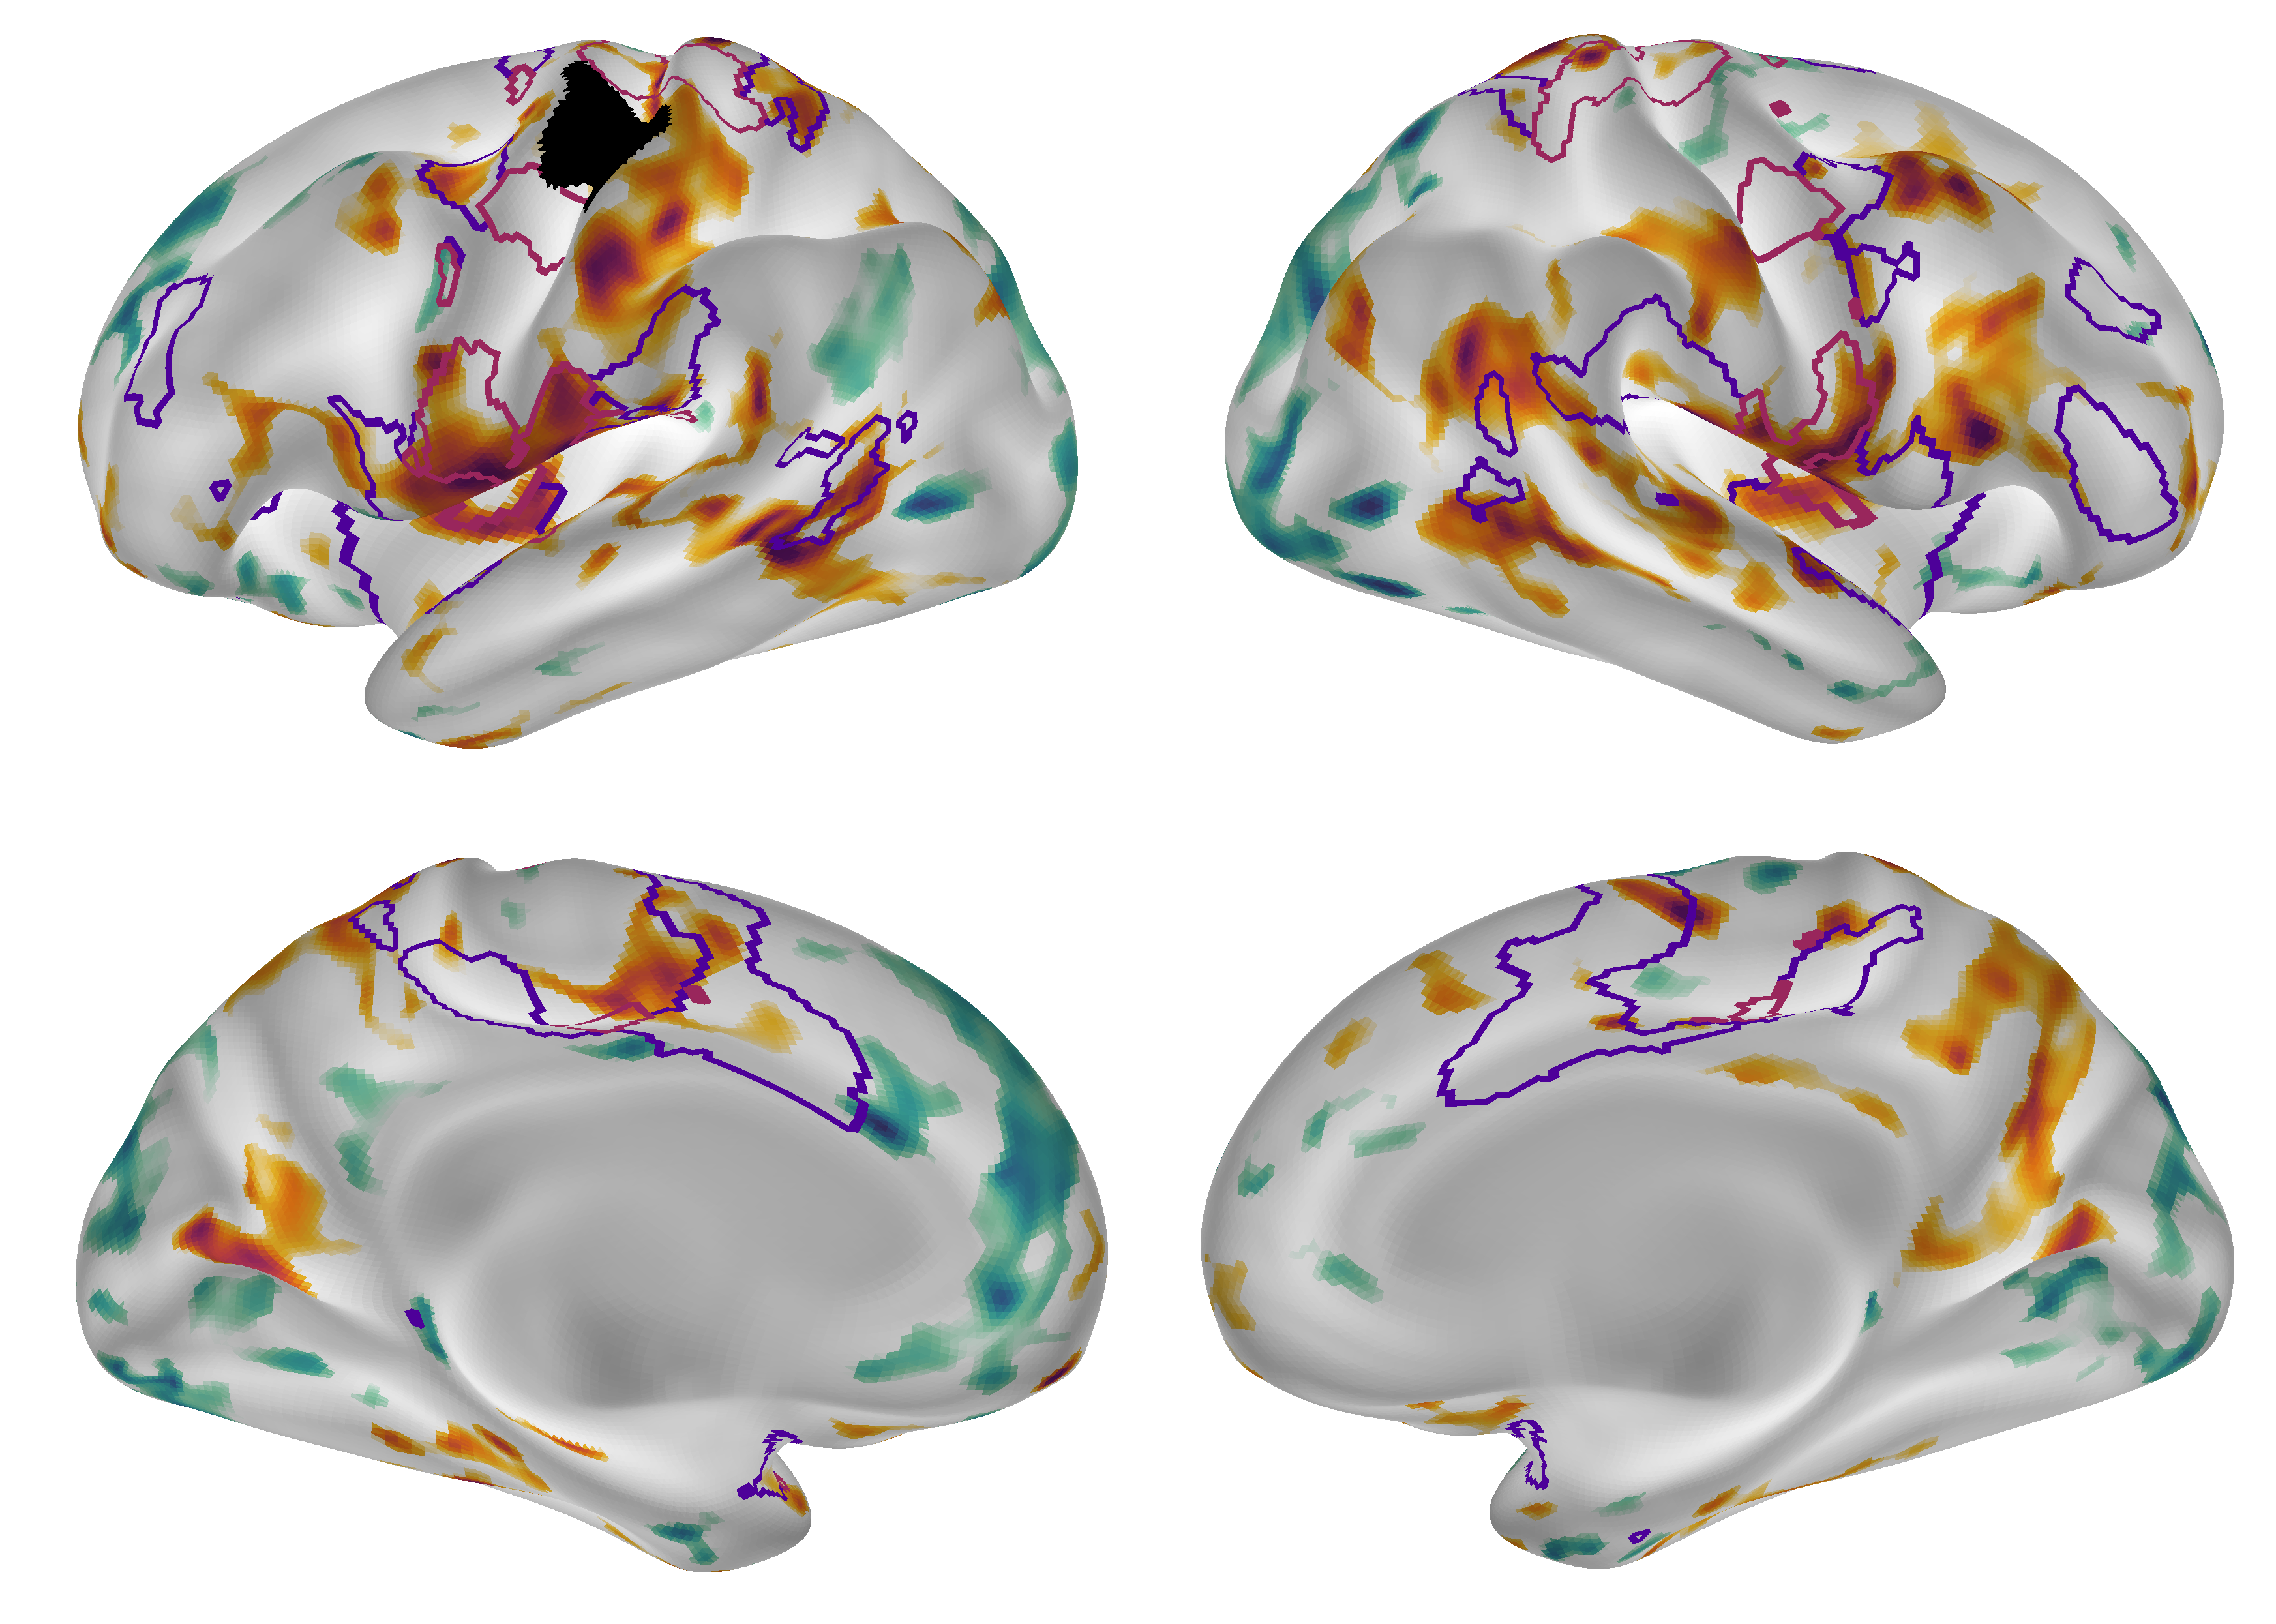

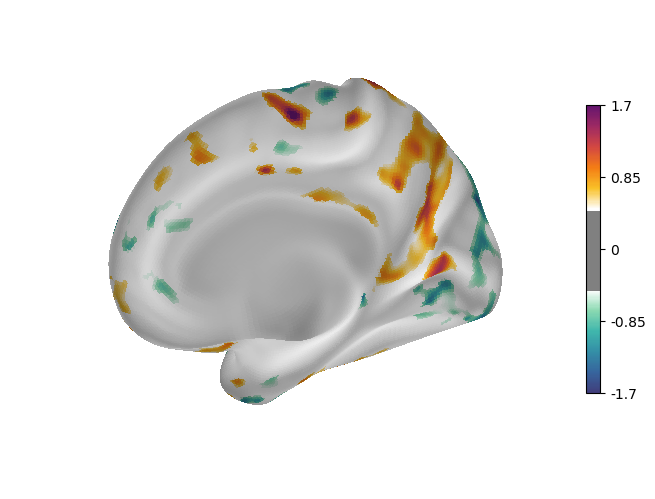

/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays.py:786: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:2794: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays.py:97: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


In [ ]:
T1path=[path+'/RosCha/Structurals/cast/bet/'+s+'/T1_masked.nii.gz' for s in sub]
sideval=[1,-1]
#e=1
#s=sub[e]
limselect=[1.7,3.4,3.4]
for e,s in enumerate(sub):#just changing the scaling of the thalamus
    for side2,side in enumerate(['L']):#,'R']):
        for comp in ['cast-pre']:#,'post-pre']:'post-cast',
            pathtest=path+'/RosCha/RestProcessing/cast/smooth255/'+s+'/FC/'
            pathorig=pathtest+comp+'_'+side+'sm1avg_dconn_cohensd.dtseries.nii'
            #mask
            pathmask=pathtest+comp+'_'+side+'sm1avg_dconn_cohensd_NClusterdetection.dtseries.nii'
            
            raw=nibabel.load(pathorig)
            origdata=copy.deepcopy(np.array(raw.dataobj[0]))

            maskdata=copy.deepcopy(np.array(nibabel.load(pathmask).dataobj[0]))
            origdata[np.where(maskdata<2)]=0
            #save it
            axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
            # You'll want the brain model axis
            time_axis, brain_model_axis = axes
            time_axis2=nibabel.cifti2.cifti2_axes.SeriesAxis(1,1,1)
            img=ci.Cifti2Image(np.array([origdata]), header=(time_axis2, brain_model_axis),
                    nifti_header=raw.nifti_header)
            ci.save(img,pathorig.replace('.dtseries.nii','_masked2cluster.dtseries.nii'))
            
            thresh=np.min(np.abs(origdata)[np.where(origdata!=0)])
            lim=limselect[e]#np.percentile(np.abs(origdata[np.where(origdata!=0)]),99)
            
            img_contour=ciftilocnet[e]
            contval=[9,18]#11,17,6,
            contcolor=[np.concatenate([i,[0.5]],0) for i in np.array(netspotcolorMOD)[[8,17]]]#10,16,5,


            mycmap=mycolorscale("matket",limpos=lim,limneg=-lim,threshold=thresh)
            handroi=path+'/RosCha/Results/Tasks/rest/'+s+'/handseed.dtseries.nii'
            plotsurfwithcontNroiProgress(pathorig.replace('.dtseries.nii','_masked2cluster.dtseries.nii'),img_contour,handroi,contval,contcolor,roipos=[side+'L'],roival=sideval[side2],vmin=-lim,vmax=lim,threshold=thresh,palette=mycmap,savefig=path+'/RosCha/Results/figures/plasticitypulses/surf_'+s+side+'SM1fc_cohensd_masked2cluster_T1_clair.pdf',rollZ=20,scale=0.6)
            
            mycmap=mycolorscale("matket",limpos=lim,limneg=-lim,threshold=thresh,Ncolor=50)
            color_listpos = [(mycmap(i)) for i in range(25,50)]#[::-1]
            color_listneg = [(mycmap(i)) for i in np.arange(24,-1,-1)]#[::-1]
            lim=[0,lim]#limmaxall[e]]
            limpos=np.concatenate([[lim[0]],[(lim[1]-lim[0])*(i+1)/24+lim[0] for i in range(24)]],0)
            #lim=[-limmaxall[e],0]
            limneg=limpos

            plt.figure(figsize=[9,10])
            plotvolindivT1(pathorig.replace('.dtseries.nii','_masked2cluster.dtseries.nii'),T1path[e],ortho='z',cut_coords=[-4,-2,-1,0,1,2,3,4,6,8,10,12],Nraw=3,colorpos=color_listpos,colorneg=color_listneg,savefig=path+'/RosCha/Results/figures/plasticitypulses/vol_'+s+side+'SM1fc_cohensd_masked2cluster_T1_clair.pdf',thresholdneg=limneg,thresholdpos=limpos,Zannotate=False,smoothing=None)
            plt.show()
            

/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays/_slicers.py:438: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


raw 0 ready
raw 1 ready
raw 2 ready


/tmp/ipykernel_198531/297237949.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(outdir,dpi=300)
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


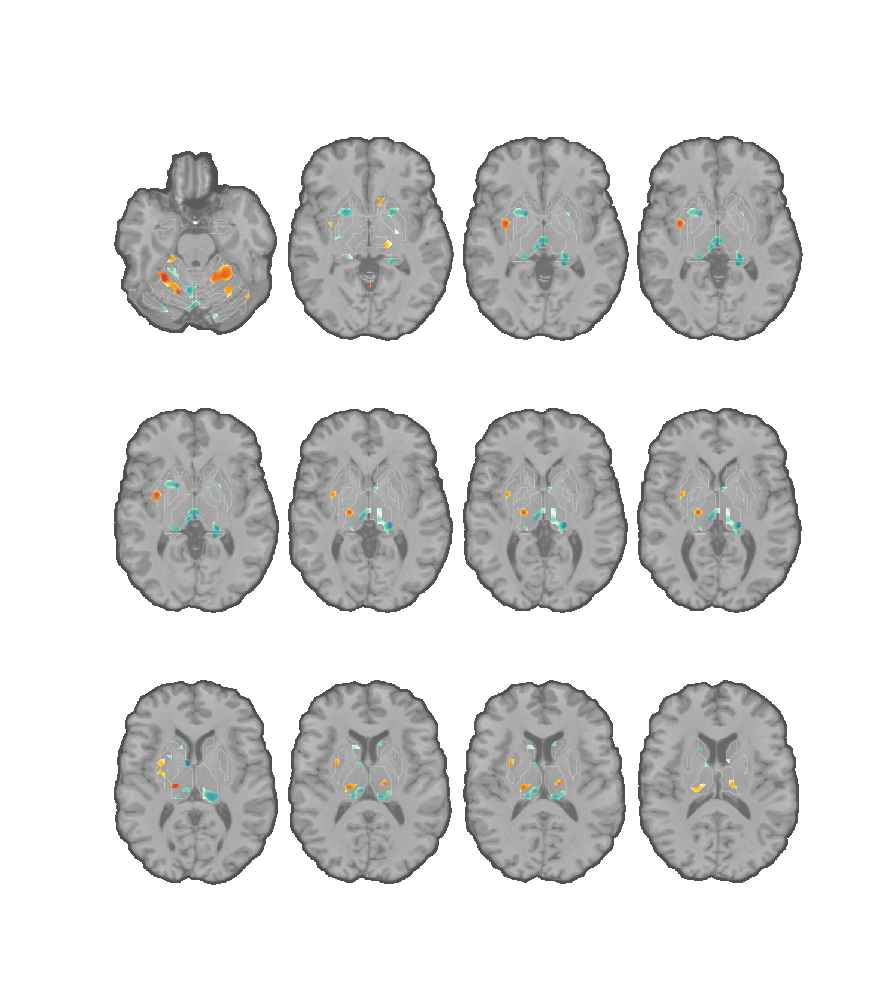

/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays/_slicers.py:438: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


raw 0 ready
raw 1 ready
raw 2 ready


/tmp/ipykernel_198531/297237949.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(outdir,dpi=300)
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


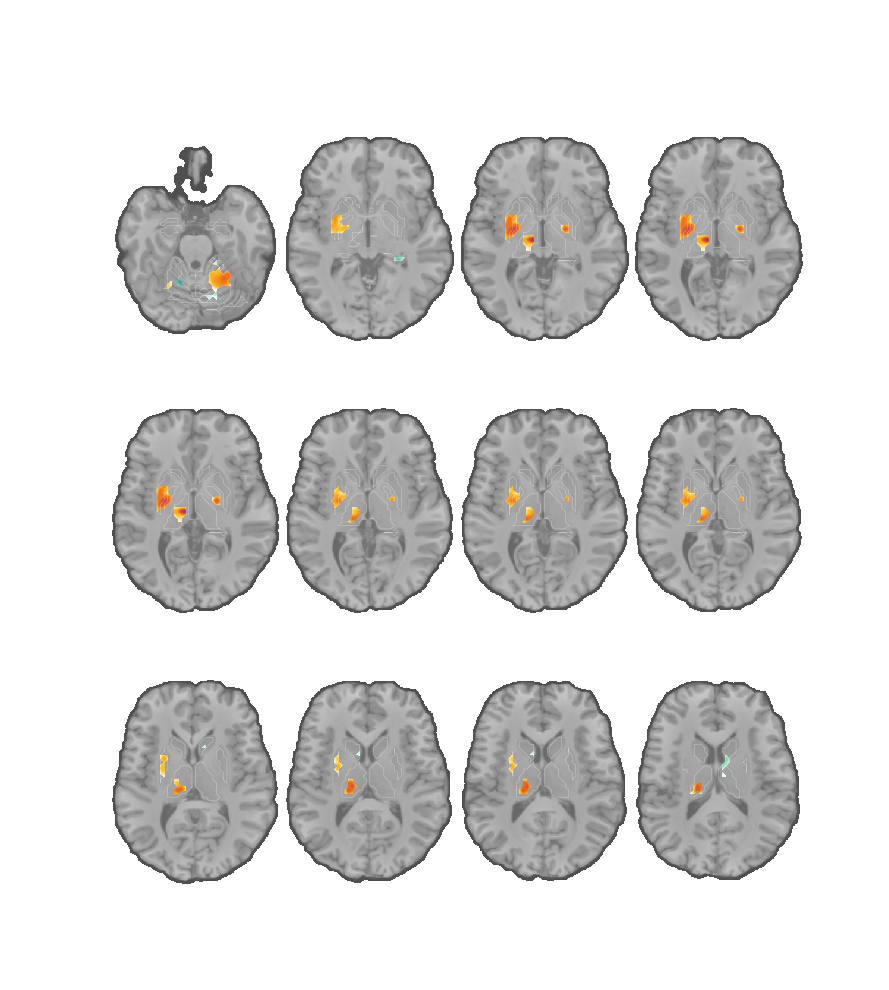

/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays/_slicers.py:438: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


raw 0 ready
raw 1 ready
raw 2 ready


/tmp/ipykernel_198531/297237949.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(outdir,dpi=300)
/data/nil-bluearc/GMT/RosCha/Tools/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


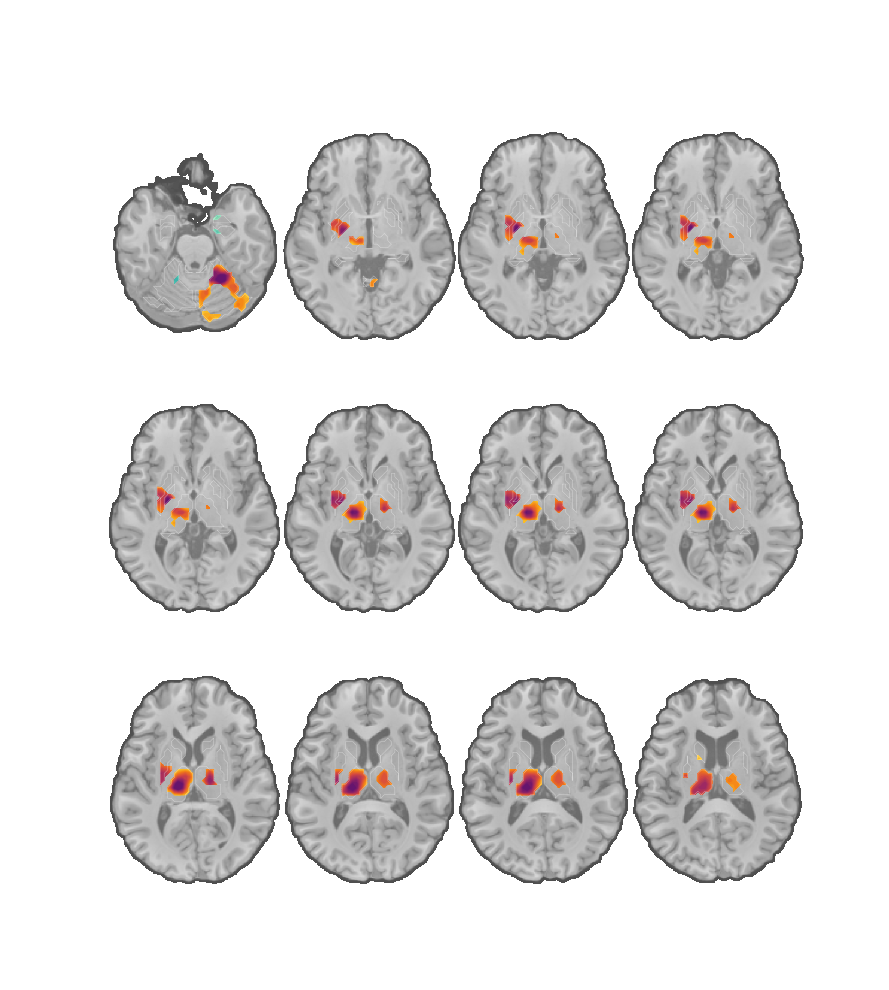

In [256]:
T1path=[path+'/RosCha/Structurals/cast/bet/'+s+'/T1_masked.nii.gz' for s in sub]
sideval=[1,-1]
#e=1
#s=sub[e]
limselect=[1.7,3.4,3.4]
for e,s in enumerate(sub):#just changing the scaling of the thalamus
    for side2,side in enumerate(['L']):#,'R']):
        for comp in ['cast-pre']:#,'post-pre']:'post-cast',
            pathtest=path+'/RosCha/RestProcessing/cast/smooth255/'+s+'/FC/'
            pathorig=pathtest+comp+'_'+side+'sm1avg_dconn_cohensd.dtseries.nii'
            #mask
            pathmask=pathtest+comp+'_'+side+'sm1avg_dconn_cohensd_NClusterdetection.dtseries.nii'
            
            raw=nibabel.load(pathorig)
            origdata=copy.deepcopy(np.array(raw.dataobj[0]))

            maskdata=copy.deepcopy(np.array(nibabel.load(pathmask).dataobj[0]))
            origdata[np.where(maskdata<2)]=0
            #save it
            axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
            # You'll want the brain model axis
            time_axis, brain_model_axis = axes
            time_axis2=nibabel.cifti2.cifti2_axes.SeriesAxis(1,1,1)
            img=ci.Cifti2Image(np.array([origdata]), header=(time_axis2, brain_model_axis),
                    nifti_header=raw.nifti_header)
            ci.save(img,pathorig.replace('.dtseries.nii','_masked2cluster.dtseries.nii'))
            
            thresh=np.min(np.abs(origdata)[np.where(origdata!=0)])
            lim=limselect[e]#np.percentile(np.abs(origdata[np.where(origdata!=0)]),99)
            
            img_contour=ciftilocnet[e]
            contval=[9,18]#11,17,6,
            contcolor=[np.concatenate([i,[0.5]],0) for i in np.array(netspotcolorMOD)[[8,17]]]#10,16,5,


            mycmap=mycolorscale("matket",limpos=lim,limneg=-lim,threshold=thresh)
            handroi=path+'/RosCha/Results/Tasks/rest/'+s+'/handseed.dtseries.nii'
            
            mycmap=mycolorscale("matket",limpos=lim,limneg=-lim,threshold=thresh,Ncolor=50)
            color_listpos = [(mycmap(i)) for i in range(25,50)]#[::-1]
            color_listneg = [(mycmap(i)) for i in np.arange(24,-1,-1)]#[::-1]
            lim=[0,lim]#limmaxall[e]]
            limpos=np.concatenate([[lim[0]],[(lim[1]-lim[0])*(i+1)/24+lim[0] for i in range(24)]],0)
            #lim=[-limmaxall[e],0]
            limneg=limpos

            plt.figure(figsize=[9,10])
            plotvolindivT1(pathorig.replace('.dtseries.nii','_masked2cluster.dtseries.nii'),T1path[e],ortho='z',cut_coords=[-21,-2,-1,0,1,2,3,4,6,8,10,12],Nraw=3,colorpos=color_listpos,colorneg=color_listneg,savefig=path+'/RosCha/Results/figures/plasticitypulses/vol_'+s+side+'SM1fc_cohensd_masked2cluster_T1_clair.pdf',thresholdneg=limneg,thresholdpos=limpos,Zannotate=False,smoothing=None)
            plt.show()
            

In [194]:
keep=[]
for e,s in enumerate(sub):#just changing the scaling of the thalamus
    for side2,side in enumerate(['L']):#,'R']):
        for comp in ['cast-pre']:#,'post-pre']:'post-cast',
            pathtest=path+'/RosCha/RestProcessing/cast/smooth255/'+s+'/FC/'
            pathorig=pathtest+comp+'_'+side+'sm1avg_dconn_cohensd.dtseries.nii'
           
            raw=nibabel.load(pathorig.replace('.dtseries.nii','_masked2cluster.dtseries.nii')).get_fdata()[0]
            
            keep+=[raw[np.nonzero(raw)]]
np.percentile(keep[0],99.5),np.percentile(np.concatenate([keep[1],keep[2]]),99.5)

(1.7532991153001836, 3.4653360009193426)

# more visu function

In [29]:
def plotvolindivThalam(ciftiloc,thalamseg,segselect='',ortho='z',cut_coords='',Nraw=1,colorpos='r',colorneg='b',savefig='', thresholdneg=False,thresholdpos=False,Zannotate='Both',smoothing=0, scale=0.8,space=5,xy=(0,1)):
    #segselect is the list of index from freesurfer segmentation we want to display, if default, all of them are taken
    raw=nibabel.load(ciftiloc)
    data=np.zeros(len(raw.dataobj[0]))
    axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
    # You'll want the brain model axis
    time_axis, brain_model_axis = axes
    #get the structure and make a temp file with level
    keepstructure=[]
    if thalamseg.find('dtseries')!=-1:
        thalamsegdata=nibabel.load(thalamseg).dataobj[0]
        if segselect=='':
            thalid=[i for i in np.unique(thalamsegdata) if i !=0]
        else:
            thalid=segselect

        data[np.where(brain_model_axis.name=='CIFTI_STRUCTURE_THALAMUS_LEFT')]=1
        data[np.where(brain_model_axis.name=='CIFTI_STRUCTURE_THALAMUS_RIGHT')]=1
        for e,b in enumerate(thalid):
            data[np.where(thalamsegdata==b)[0]]=e+2

        time_axis2=nibabel.cifti2.cifti2_axes.SeriesAxis(1,1,1)
        img=ci.Cifti2Image(np.array([data]), header=(time_axis2, brain_model_axis),
                    nifti_header=raw.nifti_header)
        ci.save(img,ciftiloc.replace('.dtseries.nii','_structuremask.dtseries.nii'))



        subprocess.call(['wb_command','-cifti-separate-all',ciftiloc.replace('.dtseries.nii','_structuremask.dtseries.nii'),'-volume',ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz'),'-left',ciftiloc.replace('.dtseries.nii','_structuremask_L.func.gii'),'-right',ciftiloc.replace('.dtseries.nii','_structuremask_R.func.gii')])
        thalamsegpath=ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz')
    else:
        thalid=segselect
        thalamsegpath=thalamseg
        thalamsegdata=nibabel.load(ciftiloc).dataobj[0]
        
        data[np.where(brain_model_axis.name=='CIFTI_STRUCTURE_THALAMUS_LEFT')]=1
        data[np.where(brain_model_axis.name=='CIFTI_STRUCTURE_THALAMUS_RIGHT')]=1
        
        time_axis2=nibabel.cifti2.cifti2_axes.SeriesAxis(1,1,1)
        img=ci.Cifti2Image(np.array([data]), header=(time_axis2, brain_model_axis),
                    nifti_header=raw.nifti_header)
        ci.save(img,ciftiloc.replace('.dtseries.nii','_structuremask.dtseries.nii'))



        subprocess.call(['wb_command','-cifti-separate-all',ciftiloc.replace('.dtseries.nii','_structuremask.dtseries.nii'),'-volume',ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz'),'-left',ciftiloc.replace('.dtseries.nii','_structuremask_L.func.gii'),'-right',ciftiloc.replace('.dtseries.nii','_structuremask_R.func.gii')])
        thalamstructure=ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz')
    subprocess.call(['wb_command','-cifti-separate-all',ciftiloc,'-volume',ciftiloc.replace('.dtseries.nii','_vol.nii.gz'),'-left',ciftiloc.replace('.dtseries.nii','_L.func.gii'),'-right',ciftiloc.replace('.dtseries.nii','_R.func.gii')])
    niftipath=ciftiloc.replace('.dtseries.nii','_vol.nii.gz')
    #cutctest=copy.deepcopy(np.array(nibabel.load(ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz')).dataobj))
    #cut_coords=np.where(cutctest!=0)
    #print(np.unique(cut_coords[0]),np.unique(cut_coords[1]),np.unique(cut_coords[2]))
    #print(stop)
    if ortho=='z':
        cut_coords=np.arange(-2,18)#np.unique(cut_coords[0])
    #if ortho=='y':
    #    cut_coords=np.unique(cut_coords[1])
    #if ortho=='x':
    #    cut_coords=np.unique(cut_coords[2])
    Nraw=np.int(np.ceil(len(cut_coords)/5.))
    #adfake=(Nraw-int(len(cut_coords)/5))*5
    #if adfake!=0:
    #    cut_coords=np.concatenate([cut_coords,[0 for i in range(adfake)]])
    print(cut_coords,Nraw)
    
    
    
    #cut_coords=cut_coords[:5]
    #Nraw=1
    
    plt.figure(figsize=[9,2*Nraw])#[9*5,10*Nraw])#3,4
    #cut_coords=[13,14,15,16,31]#cut_coords[:5]
    #Nraw=1
    
    
    
    if thalamseg.find('dtseries')!=-1:
        plotZslices_alloptionTHAL(niftipath,thalamsegpath,valmni=thalid,ortho=ortho,cut_coords=cut_coords,Nraw=Nraw,outdir=savefig,colorpos=colorpos,colorneg=colorneg,Zannotate=Zannotate,thresholdpos=thresholdpos,thresholdneg=thresholdneg,alphamap=1,alphabrain=1,smoothing=smoothing,scale=scale,space=space,xy=xy)
    else:
        plotZslices_alloptionTHAL(niftipath,thalamsegpath,thalamstructure,valmni=thalid,ortho=ortho,cut_coords=cut_coords,Nraw=Nraw,outdir=savefig,colorpos=colorpos,colorneg=colorneg,Zannotate=Zannotate,thresholdpos=thresholdpos,thresholdneg=thresholdneg,alphamap=1,alphabrain=1,smoothing=smoothing,scale=scale,space=space,xy=xy)
    
    plt.show()
    
    subprocess.call(['rm',ciftiloc.replace('.dtseries.nii','_vol.nii.gz'),ciftiloc.replace('.dtseries.nii','_L.func.gii'),ciftiloc.replace('.dtseries.nii','_R.func.gii')])
    subprocess.call(['rm',ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz'),ciftiloc.replace('.dtseries.nii','_structuremask_L.func.gii'),ciftiloc.replace('.dtseries.nii','_structuremask_R.func.gii'),ciftiloc.replace('.dtseries.nii','_structuremask.dtseries.nii')])

In [30]:

black=np.array([0,0,0])
white=np.array([1,1,1])
grayscale=get_continuous_cmap(sns.color_palette([black,white]).as_hex())
grayscale2=get_continuous_cmap(sns.color_palette([white,white]).as_hex())
def plotZslices_alloptionTHAL(niftipath,mnipath='',thalstructure='',valmni='',ortho='z',cut_coords='',Nraw=1,smoothing=None,LR=False,outdir='',colorpos='r',colorneg='b',Zannotate=False,thresholdpos='def',Zannotates='def',thresholdneg=False,alphamap=1,alphabrain=1,scale=0.8,space=5,xy=(0,1)):
    "niftipath: path to the nifti file, can be a 3D - if activation map, specify thresholds,"
    "mnipath : path to the mni T1 brain"
    "cut_coords can be a int as the number of zslices to display of a list of slices number (in MNI) (even list of one to get one specific slice)"
    "Nraw: the number of raw"
    "smoothing: number of voxel to smooth; LR:annotate left and right"
    "outdir:path to save the file"
    "color:list of color for each volume, or only one color, neg or pos if corresponding threshold to display"
    "Zannotate : Number=annotate z number, False=not annotate, Brain=on a X slice, with lign, or Both"
    "thresholdpos: specify threshold to cut and see above (can be a list for activation map: layer effect) or False will not be displayed or 'def' as 0.5 on normalized file"
    "thresholdneg: specify threshold to cut and see bellow (can be a list for activation map: layer effect) or False will not be displayed "
    import matplotlib.pyplot as plt
    import numpy as np
    import nilearn.plotting
    import nilearn.image   
    from nilearn.plotting import plot_roi, plot_stat_map
    from nilearn.plotting.find_cuts import find_cut_slices
    from nilearn.image.image import mean_img
    import nibabel
    import seaborn as sns
    initialcol=sns.light_palette((0,0,0), as_cmap=True)#'Greys'
    data=nibabel.load(niftipath)
    datasize=data.shape
    lineW=1./(Nraw+int((Zannotate=='Brain' or Zannotate=='Both')))
    mnipathtour='/opt/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz'
    if mnipath=='':
        mnipath='/opt/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz' ##this only works for the donders institute (Nijmegen, The Neterlands)
        valmni=[5000]
    else:
        if valmni=='':
            valmni=np.array([i for i in np.unique(nibabel.load(mnipath).get_fdata()) if i!=0])
            test=nibabel.load(mnipath).get_fdata()
            ignored=np.where(np.array([len(np.where(test==i)[0]) for i in valmni])<=10)[0]
            print('ignored by small size', valmni[ignored])
            valmni=valmni[~ignored]
            print('displayed', valmni)
            
    if type(cut_coords)==int or cut_coords=='':
        if cut_coords=='':
            cut_coords=6
        #find best cut
        if len(datasize)==4:
            #for 4D nifti
            cut_coords=find_cut_slices(mean_img(nibabel.nifti1.Nifti1Image(np.sign(np.abs(data.get_fdata())),data.affine)), n_cuts=cut_coords)
            print(cut_coords)
        else:
            #for 3D nifti
            cut_coords=find_cut_slices(data, n_cuts=cut_coords)
            print(cut_coords)
    
    #split in N raw
    if cut_coords!=(0,0,0):
        cut_coords=np.array(cut_coords)
        cc=cut_coords
        cut_coords=[cut_coords[int(i*len(cut_coords)/np.float(Nraw)):int((i+1)*len(cut_coords)/np.float(Nraw))] for i in range(Nraw)]
    else:
        cut_coords=[cut_coords]
    #define color as a vector (length :the number of volume):
    #if not enought color are proveded, the last of them is repeated
    #color are defined independantly for negative value display and positive value display
    if type(colorneg)==str:
        colorneg=[colorneg]
    if type(colorpos)==str:
        colorpos=[colorpos]
    if len(datasize)==4 and len(colorpos)!=datasize[3]:
        provcol=colorpos[len(colorpos)-1]
        colorpos=np.concatenate([colorpos,[provcol for i in range(datasize[3]-len(colorpos))]])
    if len(datasize)==4 and len(colorneg)!=datasize[3]:
        provcol=colorneg[len(colorneg)-1]
        colorneg=np.concatenate([colorneg,[provcol for i in range(datasize[3]-len(colorneg))]])

    #adjust threshold by normalizing image in the default version and taking 0.5
    if type(thresholdpos)==str:
        data=nibabel.nifti1.Nifti1Image(data.get_fdata()/np.float(np.max(data.get_fdata())),data.affine)
        thresholdpos=[0.5]
    #organize thresholds, more than 1 threshold to make a layer effect,
    #positive and negative values display are treated independantly:
    if type(thresholdpos)!=np.bool: thresholdpos=[i for i in np.sort(thresholdpos)]
    if type(thresholdneg)!=np.bool: 
        if np.sum(thresholdneg)<0:
            thresholdneg=[i for i in -np.sort(-1*np.array(thresholdneg))]
        else:
            thresholdneg=[i for i in np.sort(thresholdneg)]
    #load data to create a white backgroung
    func=mean_img(nibabel.nifti1.Nifti1Image(np.sign(np.abs(data.get_fdata())),data.affine))
    
    ####################subplot
    for i in range(Nraw):
        
        ax=plt.subplot(Nraw+int((Zannotate=='Brain' or Zannotate=='Both')),1,i+1)
        
        #plot the white backgroung as a zeros value brain (without it, the view focus aroung the first area plotted)
        brain=nilearn.plotting.plot_roi(nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine), nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine),colorbar=False,cut_coords=cut_coords[i],display_mode=ortho,alpha=1,draw_cross=False,cmap=initialcol,black_bg=False,axes=ax,annotate=False)
        
            
        ###############plot the volumes for Z brain slices
        if len(datasize)==3:
            iter_imgs=[data]
        else:
            iter_imgs=nilearn.image.iter_img(niftipath)
        
        j=0
        for img in iter_imgs:
            
            ##plot the positive values
            if thresholdpos!=False:
                if len(thresholdpos)==len(colorpos):
                    colorprovpos=colorpos
                else:
                    colorprovpos=sns.light_palette(colorpos[j],len(thresholdpos),reverse=True)[::-1]
                
                
                img2=nilearn.image.smooth_img(img,smoothing)
                ##plot the different threshold (layer effect) for the positive values
                for kn,k in enumerate(thresholdpos):
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovpos[kn][0],colorprovpos[kn][1],colorprovpos[kn][2]]],alpha=k/np.max(thresholdpos))#alphamap)       linewidths=lineW,             
            ##plot the negative values   
            if thresholdneg!=False:
                if len(thresholdneg)==len(colorneg):
                    colorprovneg=colorneg
                else:
                    colorprovneg=sns.light_palette(colorneg[j],len(thresholdneg),reverse=True)[::-1]
                #switch negative to positive
                img2=nibabel.nifti1.Nifti1Image(-1*nilearn.image.smooth_img(img,smoothing).get_fdata(),data.affine)
                ##plot the negatives values for each negative threshold
                for kn,k in enumerate(thresholdneg):
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovneg[kn][0],colorprovneg[kn][1],colorprovneg[kn][2]]],alpha=k/np.max(thresholdpos))#alphamap)         linewidths=lineW,           
                    
            j+=1
        
        keepsmooth=nibabel.load(mnipath)
        for v in valmni:
            prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
            prov[np.where(prov!=v)]=0
            keepsmoothprov=nibabel.Nifti1Image(prov, affine=keepsmooth.affine)
            brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, levels=[v],linewidths=lineW, cmap=grayscale)
        if thalstructure!='':
            print('yes')
            keepsmooth=nilearn.image.smooth_img(thalstructure,0.5)
            prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
            prov=np.sign(prov)
            keepsmoothprov=nibabel.Nifti1Image(prov, affine=keepsmooth.affine)
            brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, linewidths=lineW, cmap=grayscale, levels=[1.])
            
            #to gain space around
            if space!=None:
                keepsmooth=nilearn.image.smooth_img(keepsmooth,space)
                prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
                prov=np.sign(prov)
                keepsmoothprov=nibabel.Nifti1Image(prov, affine=keepsmooth.affine)
                brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, levels=[1.],linewidths=lineW, cmap=grayscale2)
        #add annotation if reauested
        if Zannotate=='Both' or Zannotate=='Number' :
            brain.annotate(left_right=LR,size=int(12*lineW))
        
        print('raw '+str(i)+' ready')
        #ax.margins(x=5, y=5)
        
        
            
        prov=ax.get_xlim()
        
        ax.set_xlim(prov[0]*scale,prov[1]*scale)
        prov=ax.get_ylim()
        ax.set_ylim(prov[0]*scale,prov[1]*scale)
        
        print(brain.axes)
        #for k in brain.axes.keys():
        #    prov=brain.axes[k].ax.get_xlim()
        #    brain.axes[k].ax.set_xlim(xy[0],xy[1])#0.2)prov[0]+(prov[1]-prov[0])*scale)
        #    brain.axes[k].ax.set_ylim(xy[0],xy[1])#brain.axes[k].ax.get_ylim()*scale)
        for cut_ax in brain.axes.values():
            cut_ax.ax.set_xlim(-30, 30)
            cut_ax.ax.set_ylim(-40, 40)
        
    ########################## plot the X brain (same process but on X)
    if Zannotate=='Brain' or Zannotate=='Both':
        print('doing annotate X slice')
        ax=plt.subplot(Nraw+1,1,Nraw+1)
        if len(datasize)==4:
            cut_coords=find_cut_slices(mean_img(nibabel.nifti1.Nifti1Image(np.sign(np.abs(data.get_fdata())),data.affine)), n_cuts=1,direction='x')
        else:
            cut_coords=find_cut_slices(data, n_cuts=1,direction='x')
        
        #plot the white background Xbrain
        brain=nilearn.plotting.plot_roi(nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine), nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine),colorbar=False,cut_coords=cut_coords,display_mode='x',alpha=1,draw_cross=False,cmap=initialcol,black_bg=False,axes=ax,annotate=False)
        
        if Zannotate=='Both' or Zannotate=='Number' :
            brain.annotate(left_right=LR,size=int(12*lineW))
            
        if len(datasize)==3:
            iter_imgs=[data]
        else:
            iter_imgs=nilearn.image.iter_img(niftipath)
        #plot the volumes
        j=0
        for img in iter_imgs:
            if thresholdpos!=False:
                if len(thresholdpos)==len(colorpos):
                    colorprovpos=colorpos
                else:
                    colorprovpos=sns.light_palette(colorpos[j],len(thresholdpos),reverse=True)[::-1]
                img2=nilearn.image.smooth_img(img,smoothing)
                
                for kn,k in enumerate(thresholdpos):
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovpos[kn][0],colorprovpos[kn][1],colorprovpos[kn][2]]],alpha=k/np.max(thresholdpos))#alphamap)                    linewidths=lineW,
                    
            if thresholdneg!=False:
                if len(thresholdneg)==len(colorneg):
                    colorprovneg=colorpneg
                else:
                    colorprovneg=sns.light_palette(colorneg[j],len(thresholdneg),reverse=True)[::-1]
                img2=nibabel.nifti1.Nifti1Image(-1*nilearn.image.smooth_img(img,smoothing).get_fdata(),data.affine)
                for kn,k in enumerate(thresholdneg):
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovneg[kn][0],colorprovneg[kn][1],colorprovneg[kn][2]]],alpha=k/np.max(thresholdpos))#alphamap)                    linewidths=lineW,
                
            j+=1

        keepsmooth=nibabel.load(mnipath)
        for v in valmni:
            prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
            prov[np.where(prov!=v)]=0
            keepsmoothprov=nibabel.Nifti1Image(prov, affine=keepsmooth.affine)
            brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, levels=[v],linewidths=lineW, cmap=grayscale)#sns.dark_palette('w', as_cmap=True),)
        if thalstructure!='':
            keepsmooth=nilearn.image.smooth_img(thalstructure,0.5)
            prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
            prov=np.sign(prov)
            keepsmoothprov=nibabel.Nifti1Image(prov, affine=keepsmooth.affine)
            brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, levels=[1.],linewidths=lineW, cmap=grayscale)
            #to gain space around
            if space!=None:
                keepsmooth=nilearn.image.smooth_img(keepsmooth,5)
                prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
                prov=np.sign(prov)
                keepsmoothprov=nibabel.Nifti1Image(prov, affine=keepsmooth.affine)
                brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, levels=[1.],linewidths=lineW, cmap=grayscale2)

        ##plot the line indicating the cut
        for i in cc:
            ax.plot([-100, 100], [i, i], 'k-',lw=lineW)#/(85.+73.)
        ax.axis((-300.0, 300.0, -80.0, 110.0))   
    #save
    if outdir!='':
        plt.savefig(outdir,dpi=300)

In [31]:
import scipy.ndimage.morphology
def plotvolindivThalamT1(ciftiloc,thalamseg,T1,segselect='',ortho='z',cut_coords='',Nraw=1,colorpos='r',colorneg='b',savefig='', thresholdneg=False,thresholdpos=False,Zannotate='Both',smoothing=0, scale=0.8,space=5,xy=(0,1),centercoor=0,dilation=0):
    #segselect is the list of index from freesurfer segmentation we want to display, if default, all of them are taken
    raw=nibabel.load(ciftiloc)
    data=np.zeros(len(raw.dataobj[0]))
    axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
    # You'll want the brain model axis
    time_axis, brain_model_axis = axes
    #get the structure and make a temp file with level
    keepstructure=[]
    if thalamseg.find('dtseries')!=-1:
        thalamsegdata=nibabel.load(thalamseg).dataobj[0]
        if segselect=='':
            thalid=[i for i in np.unique(thalamsegdata) if i !=0]
        else:
            thalid=segselect

        data[np.where(brain_model_axis.name=='CIFTI_STRUCTURE_THALAMUS_LEFT')]=1
        data[np.where(brain_model_axis.name=='CIFTI_STRUCTURE_THALAMUS_RIGHT')]=1
        for e,b in enumerate(thalid):
            data[np.where(thalamsegdata==b)[0]]=e+2

        time_axis2=nibabel.cifti2.cifti2_axes.SeriesAxis(1,1,1)
        img=ci.Cifti2Image(np.array([data]), header=(time_axis2, brain_model_axis),
                    nifti_header=raw.nifti_header)
        ci.save(img,ciftiloc.replace('.dtseries.nii','_structuremask.dtseries.nii'))



        subprocess.call(['wb_command','-cifti-separate-all',ciftiloc.replace('.dtseries.nii','_structuremask.dtseries.nii'),'-volume',ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz'),'-left',ciftiloc.replace('.dtseries.nii','_structuremask_L.func.gii'),'-right',ciftiloc.replace('.dtseries.nii','_structuremask_R.func.gii')])
        thalamsegpath=ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz')
    else:
        thalid=segselect
        thalamsegpath=thalamseg
        thalamsegdata=nibabel.load(ciftiloc).dataobj[0]
        
        data[np.where(brain_model_axis.name=='CIFTI_STRUCTURE_THALAMUS_LEFT')]=1
        data[np.where(brain_model_axis.name=='CIFTI_STRUCTURE_THALAMUS_RIGHT')]=1
        
        time_axis2=nibabel.cifti2.cifti2_axes.SeriesAxis(1,1,1)
        img=ci.Cifti2Image(np.array([data]), header=(time_axis2, brain_model_axis),
                    nifti_header=raw.nifti_header)
        ci.save(img,ciftiloc.replace('.dtseries.nii','_structuremask.dtseries.nii'))



        subprocess.call(['wb_command','-cifti-separate-all',ciftiloc.replace('.dtseries.nii','_structuremask.dtseries.nii'),'-volume',ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz'),'-left',ciftiloc.replace('.dtseries.nii','_structuremask_L.func.gii'),'-right',ciftiloc.replace('.dtseries.nii','_structuremask_R.func.gii')])
        thalamstructure=ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz')
    subprocess.call(['wb_command','-cifti-separate-all',ciftiloc,'-volume',ciftiloc.replace('.dtseries.nii','_vol.nii.gz'),'-left',ciftiloc.replace('.dtseries.nii','_L.func.gii'),'-right',ciftiloc.replace('.dtseries.nii','_R.func.gii')])
    niftipath=ciftiloc.replace('.dtseries.nii','_vol.nii.gz')
    
    if centercoor:
        print('hotspot coordinate',nilearn.plotting.find_xyz_cut_coords(niftipath))
        
    if dilation:
        raw=nibabel.load(niftipath)
        rawdata=np.array(raw.get_fdata())
        #s = scipy.ndimage.generate_binary_structure(2,1)
        if ortho=='z':#we don't want thing to appears in another plane
            orthodil=(2,2,1)
        if ortho=='x':
            orthodil=(1,2,2)
        if ortho=='y':
            orthodil=(2,1,2)
        dilated=scipy.ndimage.morphology.grey_dilation(rawdata,size=orthodil)#footprint=s)#size=(3,3,3))
        dilated[np.where(rawdata!=0)]=0
        
        rawdata+=dilated/5.
        nibabel.save(nibabel.Nifti1Image(rawdata, raw.affine, raw.header),niftipath)
        
    #cutctest=copy.deepcopy(np.array(nibabel.load(ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz')).dataobj))
    #cut_coords=np.where(cutctest!=0)
    #print(np.unique(cut_coords[0]),np.unique(cut_coords[1]),np.unique(cut_coords[2]))
    #print(stop)
    if ortho=='z':
        cut_coords=np.arange(-2,18)#np.unique(cut_coords[0])
    #if ortho=='y':
    #    cut_coords=np.unique(cut_coords[1])
    #if ortho=='x':
    #    cut_coords=np.unique(cut_coords[2])
    Nraw=np.int(np.ceil(len(cut_coords)/5.))
    #adfake=(Nraw-int(len(cut_coords)/5))*5
    #if adfake!=0:
    #    cut_coords=np.concatenate([cut_coords,[0 for i in range(adfake)]])
    print(cut_coords,Nraw)
    
    
    
    #cut_coords=cut_coords[:10]
    #Nraw=2
    
    plt.figure(figsize=[9,2*Nraw])#[9*5,10*Nraw])#3,4
    #cut_coords=[13,14,15,16,31]#cut_coords[:5]
    #Nraw=1
    
    
    
    if thalamseg.find('dtseries')!=-1:
        plotZslices_alloptionTHALT1(niftipath,thalamsegpath,T1,valmni=thalid,ortho=ortho,cut_coords=cut_coords,Nraw=Nraw,outdir=savefig,colorpos=colorpos,colorneg=colorneg,Zannotate=Zannotate,thresholdpos=thresholdpos,thresholdneg=thresholdneg,alphamap=1,alphabrain=1,smoothing=smoothing,scale=scale,space=space,xy=xy)
    else:
        plotZslices_alloptionTHALT1(niftipath,thalamsegpath,thalamstructure,T1,valmni=thalid,ortho=ortho,cut_coords=cut_coords,Nraw=Nraw,outdir=savefig,colorpos=colorpos,colorneg=colorneg,Zannotate=Zannotate,thresholdpos=thresholdpos,thresholdneg=thresholdneg,alphamap=1,alphabrain=1,smoothing=smoothing,scale=scale,space=space,xy=xy)
    
    plt.show()
    
    subprocess.call(['rm',ciftiloc.replace('.dtseries.nii','_vol.nii.gz'),ciftiloc.replace('.dtseries.nii','_L.func.gii'),ciftiloc.replace('.dtseries.nii','_R.func.gii')])
    subprocess.call(['rm',ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz'),ciftiloc.replace('.dtseries.nii','_structuremask_L.func.gii'),ciftiloc.replace('.dtseries.nii','_structuremask_R.func.gii'),ciftiloc.replace('.dtseries.nii','_structuremask.dtseries.nii')])

In [32]:
import scipy.ndimage.morphology
def plotvolindivPutamenT1(ciftiloc,T1,ortho='z',cut_coords='',Nraw=1,colorpos='r',colorneg='b',savefig='', thresholdneg=False,thresholdpos=False,Zannotate='Both',smoothing=0, scale=0.8,space=5,xy=(0,1),centercoor=0,dilation=0):
    #segselect is the list of index from freesurfer segmentation we want to display, if default, all of them are taken
    raw=nibabel.load(ciftiloc)
    data=np.zeros(len(raw.dataobj[0]))
    axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
    # You'll want the brain model axis
    time_axis, brain_model_axis = axes
    #get the structure and make a temp file with level
    keepstructure=[]


    data[np.where(brain_model_axis.name=='CIFTI_STRUCTURE_PUTAMEN_LEFT')]=1
    data[np.where(brain_model_axis.name=='CIFTI_STRUCTURE_PUTAMEN_RIGHT')]=1

    time_axis2=nibabel.cifti2.cifti2_axes.SeriesAxis(1,1,1)
    img=ci.Cifti2Image(np.array([data]), header=(time_axis2, brain_model_axis),
                nifti_header=raw.nifti_header)
    ci.save(img,ciftiloc.replace('.dtseries.nii','_structuremask.dtseries.nii'))



    subprocess.call(['wb_command','-cifti-separate-all',ciftiloc.replace('.dtseries.nii','_structuremask.dtseries.nii'),'-volume',ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz'),'-left',ciftiloc.replace('.dtseries.nii','_structuremask_L.func.gii'),'-right',ciftiloc.replace('.dtseries.nii','_structuremask_R.func.gii')])
    thalamsegpath=ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz')
    
    subprocess.call(['wb_command','-cifti-separate-all',ciftiloc,'-volume',ciftiloc.replace('.dtseries.nii','_vol.nii.gz'),'-left',ciftiloc.replace('.dtseries.nii','_L.func.gii'),'-right',ciftiloc.replace('.dtseries.nii','_R.func.gii')])
    niftipath=ciftiloc.replace('.dtseries.nii','_vol.nii.gz')
    
    if centercoor:
        print('hotspot coordinate',nilearn.plotting.find_xyz_cut_coords(niftipath))
        
    if dilation:
        raw=nibabel.load(niftipath)
        rawdata=np.array(raw.get_fdata())
        #s = scipy.ndimage.generate_binary_structure(2,1)
        if ortho=='z':#we don't want thing to appears in another plane
            orthodil=(2,2,1)
        if ortho=='x':
            orthodil=(1,2,2)
        if ortho=='y':
            orthodil=(2,1,2)
        dilated=scipy.ndimage.morphology.grey_dilation(rawdata,size=orthodil)#footprint=s)#size=(3,3,3))
        dilated[np.where(rawdata!=0)]=0
        
        rawdata+=dilated/5.
        nibabel.save(nibabel.Nifti1Image(rawdata, raw.affine, raw.header),niftipath)
        
    #cutctest=copy.deepcopy(np.array(nibabel.load(ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz')).dataobj))
    #cut_coords=np.where(cutctest!=0)
    #print(np.unique(cut_coords[0]),np.unique(cut_coords[1]),np.unique(cut_coords[2]))
    #print(stop)
    if ortho=='z':
        cut_coords=np.arange(-6,14)#np.unique(cut_coords[0])
    #if ortho=='y':
    #    cut_coords=np.unique(cut_coords[1])
    #if ortho=='x':
    #    cut_coords=np.unique(cut_coords[2])
    Nraw=np.int(np.ceil(len(cut_coords)/5.))
    #adfake=(Nraw-int(len(cut_coords)/5))*5
    #if adfake!=0:
    #    cut_coords=np.concatenate([cut_coords,[0 for i in range(adfake)]])
    print(cut_coords,Nraw)
    
    
    
    #cut_coords=cut_coords[:10]
    #Nraw=2
    
    plt.figure(figsize=[9,2*Nraw])#[9*5,10*Nraw])#3,4
    #cut_coords=[13,14,15,16,31]#cut_coords[:5]
    #Nraw=1
    
    
    
    plotZslices_alloptionTHALT1(niftipath,niftipath,thalamsegpath,T1,valmni=[],ortho=ortho,cut_coords=cut_coords,Nraw=Nraw,outdir=savefig,colorpos=colorpos,colorneg=colorneg,Zannotate=Zannotate,thresholdpos=thresholdpos,thresholdneg=thresholdneg,alphamap=1,alphabrain=1,smoothing=smoothing,scale=scale,space=space,xy=xy)
    
    plt.show()
    
    subprocess.call(['rm',ciftiloc.replace('.dtseries.nii','_vol.nii.gz'),ciftiloc.replace('.dtseries.nii','_L.func.gii'),ciftiloc.replace('.dtseries.nii','_R.func.gii')])
    subprocess.call(['rm',ciftiloc.replace('.dtseries.nii','_structuremask_vol.nii.gz'),ciftiloc.replace('.dtseries.nii','_structuremask_L.func.gii'),ciftiloc.replace('.dtseries.nii','_structuremask_R.func.gii'),ciftiloc.replace('.dtseries.nii','_structuremask.dtseries.nii')])

In [33]:

black=np.array([0,0,0])
white=np.array([1,1,1])
grayscale=get_continuous_cmap(sns.color_palette([black,white]).as_hex())
grayscale2=get_continuous_cmap(sns.color_palette([white,white]).as_hex())
def plotZslices_alloptionTHALT1(niftipath,mnipath='',thalstructure='',T1='',valmni='',ortho='z',cut_coords='',Nraw=1,smoothing=None,LR=False,outdir='',colorpos='r',colorneg='b',Zannotate=False,thresholdpos='def',Zannotates='def',thresholdneg=False,alphamap=1,alphabrain=1,scale=0.8,space=5,xy=(0,1)):
    "niftipath: path to the nifti file, can be a 3D - if activation map, specify thresholds,"
    "mnipath : path to the mni T1 brain"
    "cut_coords can be a int as the number of zslices to display of a list of slices number (in MNI) (even list of one to get one specific slice)"
    "Nraw: the number of raw"
    "smoothing: number of voxel to smooth; LR:annotate left and right"
    "outdir:path to save the file"
    "color:list of color for each volume, or only one color, neg or pos if corresponding threshold to display"
    "Zannotate : Number=annotate z number, False=not annotate, Brain=on a X slice, with lign, or Both"
    "thresholdpos: specify threshold to cut and see above (can be a list for activation map: layer effect) or False will not be displayed or 'def' as 0.5 on normalized file"
    "thresholdneg: specify threshold to cut and see bellow (can be a list for activation map: layer effect) or False will not be displayed "
    import matplotlib.pyplot as plt
    import numpy as np
    import nilearn.plotting
    import nilearn.image   
    from nilearn.plotting import plot_roi, plot_stat_map
    from nilearn.plotting.find_cuts import find_cut_slices
    from nilearn.image.image import mean_img
    import nibabel
    import seaborn as sns
    initialcol=sns.light_palette((0,0,0), as_cmap=True)#'Greys'
    data=nibabel.load(niftipath)
    datasize=data.shape
    lineW=2./(Nraw+int((Zannotate=='Brain' or Zannotate=='Both')))
    mnipathtour='/opt/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz'
    if mnipath=='':
        mnipath='/opt/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz' ##this only works for the donders institute (Nijmegen, The Neterlands)
        valmni=[5000]
    else:
        if valmni=='':
            valmni=np.array([i for i in np.unique(nibabel.load(mnipath).get_fdata()) if i!=0])
            test=nibabel.load(mnipath).get_fdata()
            ignored=np.where(np.array([len(np.where(test==i)[0]) for i in valmni])<=10)[0]
            print('ignored by small size', valmni[ignored])
            valmni=valmni[~ignored]
            print('displayed', valmni)
            
    if type(cut_coords)==int or cut_coords=='':
        if cut_coords=='':
            cut_coords=6
        #find best cut
        if len(datasize)==4:
            #for 4D nifti
            cut_coords=find_cut_slices(mean_img(nibabel.nifti1.Nifti1Image(np.sign(np.abs(data.get_fdata())),data.affine)), n_cuts=cut_coords)
            print(cut_coords)
        else:
            #for 3D nifti
            cut_coords=find_cut_slices(data, n_cuts=cut_coords)
            print(cut_coords)
    
    #split in N raw
    if cut_coords!=(0,0,0):
        cut_coords=np.array(cut_coords)
        cc=cut_coords
        cut_coords=[cut_coords[int(i*len(cut_coords)/np.float(Nraw)):int((i+1)*len(cut_coords)/np.float(Nraw))] for i in range(Nraw)]
    else:
        cut_coords=[cut_coords]
    #define color as a vector (length :the number of volume):
    #if not enought color are proveded, the last of them is repeated
    #color are defined independantly for negative value display and positive value display
    if type(colorneg)==str:
        colorneg=[colorneg]
    if type(colorpos)==str:
        colorpos=[colorpos]
    if len(datasize)==4 and len(colorpos)!=datasize[3]:
        provcol=colorpos[len(colorpos)-1]
        colorpos=np.concatenate([colorpos,[provcol for i in range(datasize[3]-len(colorpos))]])
    if len(datasize)==4 and len(colorneg)!=datasize[3]:
        provcol=colorneg[len(colorneg)-1]
        colorneg=np.concatenate([colorneg,[provcol for i in range(datasize[3]-len(colorneg))]])

    #adjust threshold by normalizing image in the default version and taking 0.5
    if type(thresholdpos)==str:
        data=nibabel.nifti1.Nifti1Image(data.get_fdata()/np.float(np.max(data.get_fdata())),data.affine)
        thresholdpos=[0.5]
    #organize thresholds, more than 1 threshold to make a layer effect,
    #positive and negative values display are treated independantly:
    if type(thresholdpos)!=np.bool: thresholdpos=[i for i in np.sort(thresholdpos)]
    if type(thresholdneg)!=np.bool: 
        if np.sum(thresholdneg)<0:
            thresholdneg=[i for i in -np.sort(-1*np.array(thresholdneg))]
        else:
            thresholdneg=[i for i in np.sort(thresholdneg)]
    #load data to create a white backgroung
    func=mean_img(nibabel.nifti1.Nifti1Image(np.sign(np.abs(data.get_fdata())),data.affine))
    if T1=='':
        T1=nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine)
    ####################subplot
    for i in range(Nraw):
        
        ax=plt.subplot(Nraw+int((Zannotate=='Brain' or Zannotate=='Both')),1,i+1)
        
        #plot the white backgroung as a zeros value brain (without it, the view focus aroung the first area plotted)
        #brain=nilearn.plotting.plot_roi(nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine), nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine),colorbar=False,cut_coords=cut_coords[i],display_mode=ortho,alpha=1,draw_cross=False,cmap=initialcol,black_bg=False,axes=ax,annotate=False)
        brain=nilearn.plotting.plot_roi(nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine), T1,dim='auto',colorbar=False,cut_coords=cut_coords[i],display_mode=ortho,alpha=1,draw_cross=False,cmap=initialcol,black_bg=False,axes=ax,annotate=False)
        
            
        ###############plot the volumes for Z brain slices
        if len(datasize)==3:
            iter_imgs=[data]
        else:
            iter_imgs=nilearn.image.iter_img(niftipath)
        
        j=0
        for img in iter_imgs:
            
            ##plot the positive values
            if thresholdpos!=False:
                if len(thresholdpos)==len(colorpos):
                    colorprovpos=colorpos
                else:
                    colorprovpos=sns.light_palette(colorpos[j],len(thresholdpos),reverse=True)[::-1]
                
                
                img2=nilearn.image.smooth_img(img,smoothing)
                ##plot the different threshold (layer effect) for the positive values
                for kn,k in enumerate(thresholdpos):
                    
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovpos[kn][0],colorprovpos[kn][1],colorprovpos[kn][2]]],alpha=k/np.max(thresholdpos))#alphamap)       linewidths=lineW,             
            ##plot the negative values   
            if thresholdneg!=False:
                if len(thresholdneg)==len(colorneg):
                    colorprovneg=colorneg
                else:
                    colorprovneg=sns.light_palette(colorneg[j],len(thresholdneg),reverse=True)[::-1]
                #switch negative to positive
                img2=nibabel.nifti1.Nifti1Image(-1*nilearn.image.smooth_img(img,smoothing).get_fdata(),data.affine)
                ##plot the negatives values for each negative threshold
                for kn,k in enumerate(thresholdneg):
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovneg[kn][0],colorprovneg[kn][1],colorprovneg[kn][2]]],alpha=k/np.max(thresholdpos))#alphamap)         linewidths=lineW,           
                    
            j+=1
        
        keepsmooth=nibabel.load(mnipath)
        for v in valmni:
            prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
            prov[np.where(prov!=v)]=0
            keepsmoothprov=nibabel.Nifti1Image(prov, affine=keepsmooth.affine)
            brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, levels=[v],linewidths=lineW, cmap=grayscale)
        if thalstructure!='':
            print('yes')
            keepsmooth=nilearn.image.smooth_img(thalstructure,0.5)
            prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
            prov=np.sign(prov)
            keepsmoothprov=nibabel.Nifti1Image(prov, affine=keepsmooth.affine)
            brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, linewidths=lineW, cmap=grayscale2, levels=[1.])
            
            #to gain space around
            #if space!=None:
            #    keepsmooth=nilearn.image.smooth_img(keepsmooth,space)
            #    prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
            #    prov=np.sign(prov)
            #    keepsmoothprov=nibabel.Nifti1Image(prov, affine=keepsmooth.affine)
            #    brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, levels=[1.],linewidths=lineW, cmap=grayscale2)
        #add annotation if reauested
        if Zannotate=='Both' or Zannotate=='Number' :
            brain.annotate(left_right=LR,size=int(12*lineW))
        
        print('raw '+str(i)+' ready')
        #ax.margins(x=5, y=5)
        
        
            
        #prov=ax.get_xlim()
        
        #ax.set_xlim(prov[0]*scale,prov[1]*scale)
        #prov=ax.get_ylim()
        #ax.set_ylim(prov[0]*scale,prov[1]*scale)
        
        #print(brain.axes)
        #for k in brain.axes.keys():
        #    prov=brain.axes[k].ax.get_xlim()
        #    brain.axes[k].ax.set_xlim(xy[0],xy[1])#0.2)prov[0]+(prov[1]-prov[0])*scale)
        #    brain.axes[k].ax.set_ylim(xy[0],xy[1])#brain.axes[k].ax.get_ylim()*scale)
        for cut_ax in brain.axes.values():
            cut_ax.ax.set_xlim(-40, 40)
            cut_ax.ax.set_ylim(-45, 35)
        
    ########################## plot the X brain (same process but on X)
    if Zannotate=='Brain' or Zannotate=='Both':
        print('doing annotate X slice')
        ax=plt.subplot(Nraw+1,1,Nraw+1)
        if len(datasize)==4:
            cut_coords=find_cut_slices(mean_img(nibabel.nifti1.Nifti1Image(np.sign(np.abs(data.get_fdata())),data.affine)), n_cuts=1,direction='x')
        else:
            cut_coords=find_cut_slices(data, n_cuts=1,direction='x')
        
        #plot the white background Xbrain
        brain=nilearn.plotting.plot_roi(nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine), nibabel.nifti1.Nifti1Image(np.zeros(func.shape),data.affine),colorbar=False,cut_coords=cut_coords,display_mode='x',alpha=1,draw_cross=False,cmap=initialcol,black_bg=False,axes=ax,annotate=False)
        
        if Zannotate=='Both' or Zannotate=='Number' :
            brain.annotate(left_right=LR,size=int(12*lineW))
            
        if len(datasize)==3:
            iter_imgs=[data]
        else:
            iter_imgs=nilearn.image.iter_img(niftipath)
        #plot the volumes
        j=0
        for img in iter_imgs:
            if thresholdpos!=False:
                if len(thresholdpos)==len(colorpos):
                    colorprovpos=colorpos
                else:
                    colorprovpos=sns.light_palette(colorpos[j],len(thresholdpos),reverse=True)[::-1]
                img2=nilearn.image.smooth_img(img,smoothing)
                
                for kn,k in enumerate(thresholdpos):
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovpos[kn][0],colorprovpos[kn][1],colorprovpos[kn][2]]],alpha=k/np.max(thresholdpos))#alphamap)                    linewidths=lineW,
                    
            if thresholdneg!=False:
                if len(thresholdneg)==len(colorneg):
                    colorprovneg=colorpneg
                else:
                    colorprovneg=sns.light_palette(colorneg[j],len(thresholdneg),reverse=True)[::-1]
                img2=nibabel.nifti1.Nifti1Image(-1*nilearn.image.smooth_img(img,smoothing).get_fdata(),data.affine)
                for kn,k in enumerate(thresholdneg):
                    brain.add_contours(img2,filled=True,levels=[k],cmap=None,colors=[[colorprovneg[kn][0],colorprovneg[kn][1],colorprovneg[kn][2]]],alpha=k/np.max(thresholdpos))#alphamap)                    linewidths=lineW,
                
            j+=1

        keepsmooth=nibabel.load(mnipath)
        for v in valmni:
            prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
            prov[np.where(prov!=v)]=0
            keepsmoothprov=nibabel.Nifti1Image(prov, affine=keepsmooth.affine)
            brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, levels=[v],linewidths=lineW, cmap=grayscale)#sns.dark_palette('w', as_cmap=True),)
        if thalstructure!='':
            keepsmooth=nilearn.image.smooth_img(thalstructure,0.5)
            prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
            prov=np.sign(prov)
            keepsmoothprov=nibabel.Nifti1Image(prov, affine=keepsmooth.affine)
            brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, levels=[1.],linewidths=lineW, cmap=grayscale2)
            #to gain space around
            '''
            if space!=None:
                keepsmooth=nilearn.image.smooth_img(keepsmooth,5)
                prov=copy.deepcopy(np.array(keepsmooth.get_fdata()))
                prov=np.sign(prov)
                keepsmoothprov=nibabel.Nifti1Image(prov, affine=keepsmooth.affine)
                brain.add_contours(keepsmoothprov,alpha=0.5*alphabrain, levels=[1.],linewidths=lineW, cmap=grayscale2)
            '''
        ##plot the line indicating the cut
        for i in cc:
            ax.plot([-100, 100], [i, i], 'k-',lw=lineW)#/(85.+73.)
        ax.axis((-300.0, 300.0, -80.0, 110.0))   
    #save
    if outdir!='':
        plt.savefig(outdir,dpi=300)

In [34]:
def subcortquantBASIC(data,raw='',method='bin',threshold=None, absolute=True):
    #method can be binary or weight
    #read the cifti with the voxel
    if type(data)==str:
        raw=nibabel.load(data)
        data=copy.deepcopy(np.array(nibabel.load(data).dataobj[0]))
    axes = [raw.header.get_axis(i) for i in range(raw.ndim)]
    # You'll want the brain model axis
    time_axis, brain_model_axis = axes
    listname=np.unique(brain_model_axis.name)
    
    
    #print(val)
    if method=='bin':
        if threshold!=None:
            if absolute:
                data[np.where(np.abs(data)<0)]=0
            else:
                data[np.where((data)<0)]=0
        data[np.where(data!=0)]=1
    relsegment=np.zeros(len(listname))
    relstructure=np.zeros(len(listname))
    relmap=np.zeros(len(listname))
    for v2,l in enumerate(listname):
        loc=np.where(brain_model_axis.name==l)[0]
    
        relsegment[v2]=np.mean(data[loc])
        relstructure[v2]=np.sum(data[loc])/len(loc)
        relmap[v2]=np.sum(data[loc])/np.sum(data)
        
    return listname,relsegment,relstructure, relmap
                
         

In [35]:
labelssegment=np.array([['8103','Left-AV','0','85','0','0'],['8104','Left-CeM','170','85','0','0'],['8105','Left-CL','0','170','0','0'],['8106','Left-CM','170','170','0','0'],['8108','Left-LD','170','255','0','0'],['8109','Left-LGN','0','0','127','0'],['8110','Left-LP','0','85','127','0'],['8111','Left-L-Sg','170','85','127','0'],['8112','Left-MDl','0','170','127','0'],['8113','Left-MDm','170','170','127','0'],['8115','Left-MGN','170','255','127','0'],['8116','Left-MV(Re)','0','0','255','0'],['8117','Left-Pc','170','0','255','0'],['8118','Left-Pf','0','85','255','0'],['8119','Left-Pt','170','85','255','0'],['8120','Left-PuA','0','170','255','0'],['8121','Left-PuI','170','170','255','0'],['8122','Left-PuL','0','255','255','0'],['8123','Left-PuM','170','255','255','0'],['8125','Left-R','255','0','0','0'],['8126','Left-VA','85','85','0','0'],['8127','Left-VAmc','255','85','0','0'],['8128','Left-VLa','85','170','0','0'],['8129','Left-VLp','255','170','0','0'],['8130','Left-VM','85','255','0','0'],['8133','Left-VPL','255','0','255','0'],['8203','Right-AV','0','85','0','0'],['8204','Right-CeM','170','85','0','0'],['8205','Right-CL','0','170','0','0'],['8206','Right-CM','170','170','0','0'],['8208','Right-LD','170','255','0','0'],['8209','Right-LGN','0','0','127','0'],['8210','Right-LP','0','85','127','0'],['8211','Right-L-Sg','170','85','127','0'],['8212','Right-MDl','0','170','127','0'],['8213','Right-MDm','170','170','127','0'],['8215','Right-MGN','170','255','127','0'],['8216','Right-MV(Re)','0','0','255','0'],['8217','Right-Pc','170','0','255','0'],['8218','Right-Pf','0','85','255','0'],['8219','Right-Pt','170','85','255','0'],['8220','Right-PuA','0','170','255','0'],['8221','Right-PuI','170','170','255','0'],['8222','Right-PuL','0','255','255','0'],['8223','Right-PuM','170','255','255','0'],['8225','Right-R','255','0','0','0'],['8226','Right-VA','85','85','0','0'],['8227','Right-VAmc','255','85','0','0'],['8228','Right-VLa','85','170','0','0'],['8229','Right-VLp','255','170','0','0'],['8230','Right-VM','85','255','0','0'],['8233','Right-VPL','255','0','255','0'],['226','HP_tail','170','170','255','0'],['227','Polymorphic-Layer','128','255','128','0'],['228','Intracellular-Space','204','153','204','0'],['231','HP_body','0','255','0','0'],['232','HP_head','255','0','0','0'],['7001','Lateral-nucleus','72','132','181','0'],['7002','Basolateral-nucleus','243','243','243','0'],['7003','Basal-nucleus','207','63','79','0'],['7004','Centromedial-nucleus','121','20','135','0'],['7005','Central-nucleus','197','60','248','0'],['7006','Medial-nucleus','2','149','2','0'],['7007','Cortical-nucleus','221','249','166','0'],['7008','Accessory-Basal-nucleus','232','146','35','0'],['7009','Corticoamygdaloid-transitio','20','60','120','0'],['7010','Anterior-amygdaloid-area-AAA','250','250','0','0'],['7011','Fusion-amygdala-HP-FAH','122','187','222','0'],['7012','Hippocampal-amygdala-transition-HATA','237','12','177','0'],['7013','Endopiriform-nucleus','10','49','255','0'],['7014','Lateral-nucleus-olfactory-tract','205','184','144','0'],['7015','Paralaminar-nucleus','45','205','165','0']])

In [36]:
labelssegmentTHOMAS=np.array(['left/2-AV','left/4-VA','left/5-VLa','left/6_VLPv','left/6_VLPd','left/7-VPL','left/8-Pul','left/9-LGN','left/10-MGN','left/11-CM','left/12-MD-Pf','left/13-Hb','left/14-MTT','right/2-AV','right/4-VA','right/5-VLa','right/6_VLPv','right/6_VLPd','right/7-VPL','right/8-Pul','right/9-LGN','right/10-MGN','right/11-CM','right/12-MD-Pf','right/13-Hb','right/14-MTT'])